# __*MULTIOUTPUT REGRESSION TREES*__

## __*IMPORT LIBRARIES*__

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score,KFold
from sklearn.feature_selection import SelectFromModel,RFECV

from sklearn.tree import DecisionTreeRegressor,plot_tree
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error, root_mean_squared_error
from pandas.plotting import table

from tabulate import tabulate



## __*PREPARE DATA*__

I would like to have something somewhat accessible given that the analysis is made for and through recreational athletes. This is why all the skinfold metrics will not be part ofthe analysis given that it would be very rare and difficult for a recretional athlet to acquire all of this specifics.

GOAL :

- ```half/full marathon finishing time``` -> The time goal of the recreational athlete.

__UNCHANGED VALID INPUT DATA (X):__

This is data that the athlete cannot change and can all be used as input for the model to make predictions. 

An assumption is made : The athlete will be checking the improvements needed for the next __RACE__. This means that the model gives suggestion based on the current situation of the athlete and hence the columns ```numHalfMarathon``` and ```numMarathons``` will be treated as unchanged data. I assume that this is something the athlete cannot change.

- __marathon_time_in_minutes__: This is the best marathon time ever recorded by the athlete
- __height__: height of the athlete
- __age__ : age ofthe athlete
- __HRmax__ : Maximal heart rate bpm possible of the athlete
- __yeasTrained__ : The amount of years an athlete has been training for
- __numHalfMarathon__ : Number of half marathon ever ran by the athlete
- __numMarathons__ : Number of marathons ever ran by the athlete

__OUTPUT OF THE MODEL (Y):__

The rest of the columns that remain in __cleaned_dataset.csv__

In [2]:
data = pd.read_csv('cleaned_data.csv')
data = data.dropna(subset=['marathon_time_in_minutes'])
X_marathon = data[['marathon_time_in_minutes','height','age','HRmax','yearsTrained','Halfmarathon_min','FFM', 'bmi']] 
y_marathon = data.drop(columns=[
    'marathon_time_in_minutes',
    'id',
    'Halfmarathon_min',
    'height',
    'age',
    'HRmax',
    'skinfoldCheek', ''
    'skinfoldChin',
    'skinfoldTriceps',
    'skinfoldSubscapular',
    'skinfoldChestI', 
    'skinfoldChestII',
    'skinfoldAbdominal', 
    'skinfoldSuprailiac', 
    'skinfoldThigh',
    'skinfoldCalf', 
    'skinfoldBiceps',
    'yearsTrained',
    'numHalfMarathon',
    'numMarathons'
    ]) 

X_marathon.isnull().sum()

marathon_time_in_minutes    0
height                      0
age                         0
HRmax                       0
yearsTrained                0
Halfmarathon_min            0
FFM                         0
bmi                         0
dtype: int64

## __*AUXILLIARY FUNCTIONS - DISPLAY TABLES, DISPLAY TREES etc...*__ 

In [3]:
def create_metric_table(df,title,indexes,ax):
    """
    Crete an image of a well structure image for better readability of metrics

    Parameters
    -
    df : pandas.DataFrame or numpy.ndarray
        Dataframe of the data to be displayed in the tab;e.
    title : string
        A string denoting the title of the table
    indexs : Array
        A series of indexes meaning name of the rows
    ax : Any
        Axes of the image where thetable to be displayed
    
    Returns -
        -
    -
    """

    df.index = indexes

    ax.set_frame_on(False)  
    ax.axis('off')

    header_color = 'blue'
    row_colors = ['#f4f4f8', '#ffffff'] 

    table_data = df.reset_index().values.tolist()  
    column_labels = ['Model'] + list(df.columns) 

    table = ax.table(
        cellText=table_data,
        colLabels=column_labels,
        cellLoc='center',
        loc='center',
        colColours=[header_color] * len(column_labels), 
    )

    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)

    for i, key in table._cells.items():
        cell = table._cells[i]
        # TITLE!! whiteon blue
        if i[0] == 0:  
            cell.set_text_props(weight='bold', color='white')
        else:  
            cell.set_facecolor(row_colors[i[0] % len(row_colors)])
    
    ax.set_title(title, fontsize=12, fontweight="bold") 

In [4]:
def markdown_table(single_metrics,y):
    """
    Creates a well structured dictionary of 

    Parameters
    -
    single_metrics : dict
        mapping of the metrics with respective values    
    
    Returns  
    -
    dict
        correct spaced metrics mapping
    """
    
    formatted_single_metrics = {
    'MSE' : [],
    'MAE' : [],
    'R2-SCORE' : []
    }

    for i,metric in enumerate(single_metrics):
        tmp = []
        for j,specific_metric in enumerate(single_metrics[metric]):
            tmp_inner = []
            for l in range(len(single_metrics[metric][j])):
                tmp_inner.append(f'{y.columns[l]} : {single_metrics[metric][j][l]}')

            tmp.append("\n".join(tmp_inner)) #REMMEBERRR THIS!!!!! always join with \n ndon't put \n inside above, 

        formatted_single_metrics[metric] = tmp
    
    return formatted_single_metrics


In [5]:
def print_intervals(feature,results):  
    """
    well structured printing of the prediction intervals 

    Parameters
    -
    feature : String
        A string name of the analysed column
    results : pandas.Dataframe 
        A Dataframe consisting of all results of percentiles and actual predictionof the specified column
    
    Returns  
    -
    prints directly the well spaced and formatted markdown tables
    """
    
    rf_full = results[[ f"rf_lower_{feature}", f"rf_pred_{feature}", f"rf_upper_{feature}"]]
    et_full = results[[ f"et_lower_{feature}", f"et_pred_{feature}", f"et_upper_{feature}"]]

    print("RF Predictions & Intervals:\n", rf_full, '\n')
    print("ET Predictions & Intervals:\n", et_full, '\n')

In [6]:

def plot_histogram_single_features(usr_input,title,y_axis,x_axis):
    # Feature names and their corresponding "realization" values
    features = list(usr_input.keys())
    values = [] 
    for i,ft in enumerate(features):
        values.append(usr_input[ft])


    # Plotting
    plt.figure(figsize=(8, 5))
    bars = plt.bar(features, values, color='skyblue', edgecolor='black')

    # Add value labels on top of each bar
    for bar, importance in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                 f'{importance:.2f}', ha='center', va='bottom', fontsize=10)

    plt.title(f'{title}', fontsize=14)
    plt.ylabel(y_axis)
    plt.xlabel(x_axis)

    mx = 0
    for val in values:
        if val > mx :
            mx = val

    plt.ylim(0, mx + 10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

In [7]:
def compute_K_fold(regressor,X,y,splits):
    scores=[] 
    rmse_list=[]
    model = regressor(random_state=42)
    cv = KFold(n_splits=splits, random_state=42, shuffle=True)
    for train_index, test_index in cv.split(X):
        X_train, X_validation, y_train, y_validation = X.iloc[train_index], X.iloc[test_index], y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train, y_train)
        y_predict = model.predict(X_validation)
        scores.append(np.mean(r2_score(y_validation, y_predict, multioutput="raw_values")))
        rmse_list.append(np.mean(root_mean_squared_error(y_validation,y_predict,  multioutput='raw_values')))

    return scores,rmse_list

## __*PERFORM GRID SEARCHING FOR CROSSVALIDATION*__

Prepare both grid searching for normal tree and ensemble

CrossValidation for the tuning of the parameters of the tree. Tuning max_depth, max_features, min_samples_split, min_samples_leaf. This should be returning the best hyperarameters for the trees in order to have the minimun mse with the best splits. As always it woould be good not to blindly rely on what grid search directly returns but i.e the depth ofthe tree can be adjusted to decide if there is too much oiverfitting or underfitting.

Split X and y into k folds (e.g., cv=5 means 5 splits).

For each combination of hyperparameters:

It performs 5 iterations:

In each iteration, it uses 4 folds for training and 1 fold for validation.

It computes the average validation score for that parameter combo.

We need to fit the regressor onto the training data so that it then splits the data into training and validation

In [ ]:
def grid_searching(regressor, X, y, percentage, ensemble,seed):
    """
    Performs grid search to fine-tune hyperparameters of tree-based regressors.

    Parameters
    -
    regressor : class
        A scikit-learn regression model (e.g., DecisionTreeRegressor, RandomForestRegressor).
    X : pandas.DataFrame or numpy.ndarray
        Feature matrix used for training.
    y : pandas.Series or numpy.ndarray
        Target variables.
    ensemble : bool
        If True, assumes the regressor is an ensemble method and applies specific hyperparameter tuning.

    Returns
    -
    dict
        Best hyperparameters found during grid search.
    """

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=percentage, random_state=seed)

    param_grid = {
        'max_depth': range(5, 12), 
        'max_features': [None, 'sqrt', 'log2', 0.5], 
        'min_samples_split': range(2,15),
        'min_samples_leaf': range(1,10) 
    }

    if ensemble :
        param_grid['n_estimators'] = [100,200,300]

    # NOTE: By fitting the data onto the training set then GridSearch will split into validation and training
    tree = regressor(random_state=42)
    grid_search = GridSearchCV(tree, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    print("The Best Parameters are :", grid_search.best_params_)
    print("The Best negative MSE Score is :", grid_search.best_score_)

    return grid_search.best_params_, grid_search.best_score_, grid_search.best_estimator_

The analysis will be made on trees and ensemble that already can handle multioutput regression :

- Decision Tree Regressor
- Random Forest Regressor
- Extra Tree Regressor

In [ ]:
gs_dt, gs_scores, grid_searched_tree = grid_searching(DecisionTreeRegressor, X_marathon, y_marathon, 0.2, False,42)
gs_rf, gs_scores, grid_searched_rf = grid_searching(RandomForestRegressor, X_marathon, y_marathon, 0.2, True,42)
gs_extra, gs_scores, grid_searched_extra= grid_searching(ExtraTreesRegressor, X_marathon, y_marathon, 0.2, True,42)

The Best Parameters are : {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 9, 'min_samples_split': 2}
The Best negative MSE Score is : -886.0713556703389


/home/lamberto/.local/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


The Best Parameters are : {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 14, 'n_estimators': 200}
The Best negative MSE Score is : -827.3787713593389


/home/lamberto/.local/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


The Best Parameters are : {'max_depth': 5, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 200}
The Best negative MSE Score is : -825.6550421949269


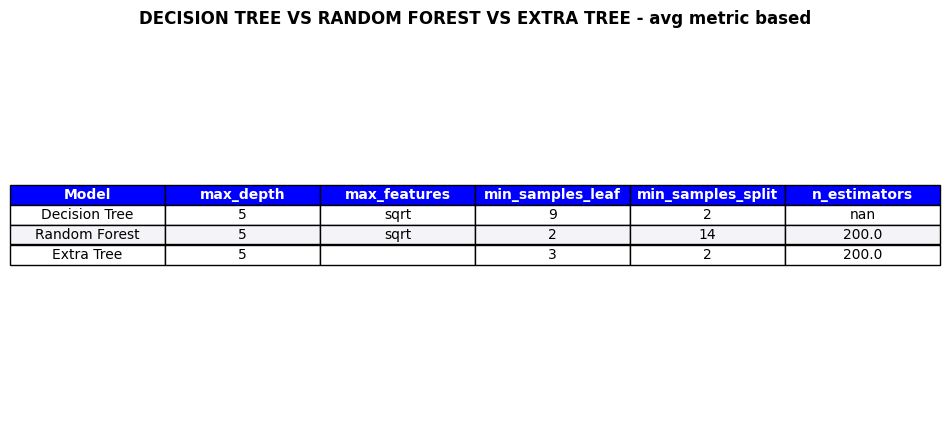

In [ ]:
best_params = {
    'max_depth': [gs_dt['max_depth'], gs_rf['max_depth'], gs_extra['max_depth']],
    'max_features':[gs_dt['max_features'], gs_rf['max_features'], gs_extra['max_features']],
    'min_samples_leaf': [gs_dt['min_samples_leaf'], gs_rf['min_samples_leaf'], gs_extra['min_samples_leaf']],
    'min_samples_split': [gs_dt['min_samples_split'], gs_rf['min_samples_split'], gs_extra['min_samples_split']],
    'n_estimators' : [None, gs_rf['n_estimators'], gs_extra['n_estimators'] ]
}

pd_grid_search = pd.DataFrame(best_params)
indexes = ['Decision Tree', 'Random Forest', 'Extra Tree']
size = (10,5)

fig, axes = plt.subplots(figsize=(10,5))  
create_metric_table(pd_grid_search, 'DECISION TREE VS RANDOM FOREST VS EXTRA TREE - avg metric based', indexes, axes)

## __*REGRESSION FUNCTION - TRAINS, PREDICTS AND EVALUATES THE REGRESSORS*__

In this case it is possible to try to blindly rely on what grid searching is suggesting and analysis the performance through mse,mae and r2 score. Once analyzed it would also be possible to have a visual visualization and decide if some pruning can done or maybe if some more layers would help the performance

In [55]:
def perform_tree_regression(regressor,X,y,ensemble,seed):
    """
    Performs the training, prediction and metric evaluation of the given regressor.

    Parameters
    -
    regressor : class
        A scikit-learn regression model (e.g., DecisionTreeRegressor, RandomForestRegressor).
    X : pandas.DataFrame or numpy.ndarray
        Feature matrix used for training.
    y : pandas.Series or numpy.ndarray
        Target variabls.
    ensemble : bool
        If True, assumes the regressor is an ensemble method and applies the correct set of hyperparameter.

    Returns
        trained regressor, training set, metrics
    -
    tuple
        [regressor,training set, avg mse, avg mae, avg r2-score]
    """

    X_tmp, X_test, y_tmp, y_test = train_test_split(X,y, test_size=0.2, random_state=seed)

    # NOTE: now the 100% of data here is just 80% of total
    X_train, X_validation, y_train, y_validation= train_test_split(X_tmp,y_tmp, test_size=0.125, random_state=seed)

    print(X_train)
    print(X_validation)
    print(y_train)
    print(y_validation)  

    # NOTE: REMEMBER!! we want to have GridSearch on validation test
    # NOTE: GridSearch returns already the fitted model !
    gs,scores,model = grid_searching(regressor,X_tmp,y_tmp, 0.125, ensemble)

    # params = {
    #     "max_depth" :gs['max_depth'],
    #     "max_features" : gs['max_features'],
    #     "min_samples_leaf" : gs['min_samples_leaf'],
    #     "min_samples_split" : gs['min_samples_split'],
    # }

    # if ensemble :
    #     params["n_estimators"] = gs['n_estimators']
    
    # tree = regressor(**params,random_state=42)
    # tree.fit(X_train,y_train)  
    # predictions = tree.predict(X_validation)

    predictions = model.predict(X_validation)

    mae = mean_absolute_error(y_validation, predictions, multioutput='raw_values')
    mse = mean_squared_error(y_validation, predictions, multioutput='raw_values')
    r2 = r2_score(y_validation, predictions, multioutput='raw_values')
    # mape = mean_absolute_percentage_error(y_validation, predictions)
    # mape_single = [mean_absolute_percentage_error(y_validation.iloc[:, i], predictions[:, i]) for i in range(y_test.shape[1])]
    root_mse = root_mean_squared_error(y_validation,predictions,  multioutput='raw_values')
    
    # NOTE: removed -> mape,mape_single 
    return model,X_train,mse,mae,r2,root_mse

## __*PERFORM FEATURE EXTRACTION*__

__FEATURE SELECTION__

After having crossvalidated the models, it is better to make some feature extraction. Feature extraction shows what are the predictors that are less important in the analysis. It means that they don't impact the predictions. This way it is possible to reduce the input X by both simplifying the model which is good in this case and eliinating useless predictors.

In [160]:
def Feature_extraction(regressor,X,y,gs,ensemble,seed):
    """
    Performs Feature exctraction, It returns only the important predictor variables for the already crossvalidated model

    Parameters
    -
    regressor : class
        A scikit-learn regression model (e.g., DecisionTreeRegressor, RandomForestRegressor).
    X : pandas.DataFrame or numpy.ndarray
        Feature matrix used for training.
    y : pandas.Series or numpy.ndarray
        Target variabls.
    ensemble : bool
        If True, assumes the regressor is an ensemble method and applies the correct set of hyperparameter.

    Returns
    -
    tuple
        Dataframe of Selected features
    """

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=seed) 

    params = {
        "max_depth" :gs['max_depth'],
        "max_features" : gs['max_features'],
        "min_samples_leaf" : gs['min_samples_leaf'],
        "min_samples_split" : gs['min_samples_split'],
    }

    if ensemble :
        params["n_estimators"] = gs['n_estimators']

    # NOTE: model alrady fine-tuned with Grid Search
    model = regressor(**params,random_state=42)
    model.fit(X_train, y_train)

    # NOTE: prefit=True means model is alredy fitted
    selector = SelectFromModel(model, threshold="mean", prefit=True) 
    selected_features = X_train.columns[selector.get_support()]

    return selected_features,model

In [ ]:
def Feature_selection_through_rfecv(regressor,X,y,ensemble,gs,title,seed):
    """
    Performs Feature exctraction, It returns the graph in realtion to negative men square error with the number of selected features
    Prints the selected features

    Parameters
    -
    regressor : class
        A scikit-learn regression model (e.g., DecisionTreeRegressor, RandomForestRegressor).
    X : pandas.DataFrame or numpy.ndarray
        Feature matrix used for training.
    y : pandas.Series or numpy.ndarray
        Target variabls.
    ensemble : bool
        If True, assumes the regressor is an ensemble method and applies the correct set of hyperparameter.
    gs : dict
        dictionary of fine tuned hyperparameters of regression trees.
    title: string
        Title of the plot 

    Returns
    -
    - 
    """

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=seed)

    params = {
        "max_depth" : gs['max_depth'],
        "max_features" : gs['max_features'],
        "min_samples_leaf" : gs['min_samples_leaf'],
        "min_samples_split" : gs['min_samples_split'],
    }

    if ensemble:
        params["n_estimators"] = gs['n_estimators']

    # NOTE: in this case model was not prefit and instance of RFECV is running K-fold crossval to check everything
    model = regressor(**params,random_state=42)
    rfecv = RFECV(estimator=model, step=2, cv=5, scoring="neg_mean_squared_error")
    rfecv.fit(X_train, y_train)

    print(f"Optimal number of features: {rfecv.n_features_}")
    print(f"Selected features: {X.columns[rfecv.support_]}")

    plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
    plt.xlabel("Number of Features Selected")
    plt.ylabel("neg_mean_squared_error")
    plt.title(title)
    plt.show()

__PERFORM FEATURE EXTRACTION ON THE ANALYZED MODELS__

In [ ]:
dt_features,tree = Feature_extraction(DecisionTreeRegressor,X_marathon,y_marathon,gs_dt,False,42)
rf_features,rf = Feature_extraction(RandomForestRegressor,X_marathon,y_marathon,gs_rf,True,42)
extra_features,extra = Feature_extraction(ExtraTreesRegressor,X_marathon,y_marathon,gs_extra,True,42)

__IMPORTANCE OF THE FEATURES__

In [163]:
dt_importances = tree.feature_importances_
rf_importances = rf.feature_importances_
extra_imporances = extra.feature_importances_

reg_arr = ['DecisionTreeRegressor', 'RandomForestRegressor', 'ExtraTreesRegressor']
imp_arr = [dt_importances,rf_importances,extra_imporances]

for i in range(len(imp_arr)):
    print('*' * 200)
    print(f'REGRESSOR : {reg_arr[i]} ')
    for j,col in enumerate(X_marathon.columns):
        print(f'importance of {col} : {imp_arr[i][j]}')

print('*' * 200)

********************************************************************************************************************************************************************************************************
REGRESSOR : DecisionTreeRegressor 
importance of marathon_time_in_minutes : 0.22945353121354134
importance of height : 0.051890582724083936
importance of age : 0.11028008773321939
importance of HRmax : 0.0
importance of yearsTrained : 0.11190015305386344
importance of Halfmarathon_min : 0.0
importance of FFM : 0.45813063914733176
importance of bmi : 0.03834500612796007
********************************************************************************************************************************************************************************************************
REGRESSOR : RandomForestRegressor 
importance of marathon_time_in_minutes : 0.10866347108452738
importance of height : 0.13701979968084047
importance of age : 0.17013126924905472
importance of HRmax : 0.056656770966557975
impo

In [164]:
features_arr = [dt_features,rf_features,extra_features]
reg_arr = ['Decision Tree', 'Random Forest', 'Extra tree']

for i,ft in enumerate(features_arr):
    print(f'The selected features for model -> {reg_arr[i]} are : {ft}')

The selected features for model -> Decision Tree are : Index(['marathon_time_in_minutes', 'FFM'], dtype='object')
The selected features for model -> Random Forest are : Index(['height', 'age', 'FFM'], dtype='object')
The selected features for model -> Extra tree are : Index(['age', 'FFM'], dtype='object')


Optimal number of features: 6
Selected features: Index(['marathon_time_in_minutes', 'height', 'age', 'yearsTrained', 'FFM',
       'bmi'],
      dtype='object')


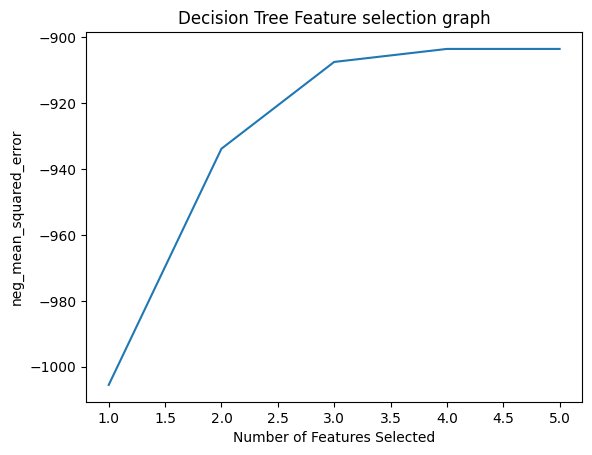

Optimal number of features: 8
Selected features: Index(['marathon_time_in_minutes', 'height', 'age', 'HRmax', 'yearsTrained',
       'Halfmarathon_min', 'FFM', 'bmi'],
      dtype='object')


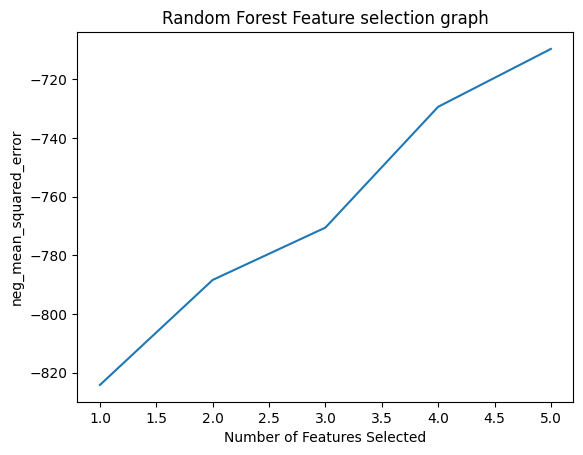

Optimal number of features: 8
Selected features: Index(['marathon_time_in_minutes', 'height', 'age', 'HRmax', 'yearsTrained',
       'Halfmarathon_min', 'FFM', 'bmi'],
      dtype='object')


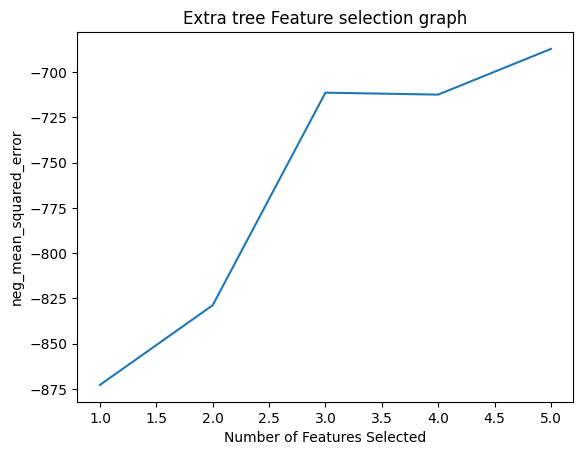

In [ ]:
Feature_selection_through_rfecv(DecisionTreeRegressor,X_marathon,y_marathon,False,gs_dt,"Decision Tree Feature selection graph",42)
Feature_selection_through_rfecv(RandomForestRegressor,X_marathon,y_marathon,True,gs_rf, "Random Forest Feature selection graph",42)
Feature_selection_through_rfecv(ExtraTreesRegressor,X_marathon,y_marathon,True,gs_extra,"Extra tree Feature selection graph",42)

__CONSIDERATIONS__

- SlectFromModel:

    The normal regression tree wouldn't even take into consideration the time in the SelectFromModel one...Though, the time is something that we mandatorily need because its the athlee goal so it is a vital predictor. Based on my implementaion choice I will be keeping ```yearsTrained``` because it is something that effectively impact the finishing time and overall is the fourth on the list of importances. Obviously in the multioutput model the aim is not to predict the time but to predict other carchteristics but for some of the predicted variables the amount of years that a person has been training for can actually influence a bit so I will be keeping it.

- RFECV:

    All of them suggest 5 fetures insted of 3 as the SelectedFRomModel, all seem to be in agreement on keeping height,age nd obviously marathon time. Yerstrained is kept just by the ensemble and numHalfmarathon is also kept...Personally I think that a certain number of halfmarathon ran can effectively help in the prediction of  marathon time given experience but still as an implementation choice I would leave it out from the predictors given that itwould mainly help under an experience point of view and not by a proper metric.

- X space :

    - marathon_time_in_minutes
    - height
    - age
    - yearsTrained



## __*TRAIN AND EVALUATE THE MODELS*__

Recreate the X input set based on what Feature exctraction returned. As always remember that it is onot advised to blindly follow what the automated process returned but it is possible to make some implementation choice based on proper research, knoledge or reliable intuition. This means that it is possible anyway to add or remove features that were or were not selected in the feature extraction process

__RECREATE THE X INPUT SPACE__

In [ ]:
X_marathon = data[extra_features].copy() 
X_marathon.loc[:, 'yearsTrained'] = data['yearsTrained']  
X_marathon.columns

Index(['marathon_time_in_minutes', 'height', 'age', 'yearsTrained'], dtype='object')

__TRAIN THE MODELS__

In [ ]:
tree1, tree_train1, tree_mse1, tree_mae1, tree_r21, tree_root1 = perform_tree_regression(DecisionTreeRegressor,X_marathon,y_marathon,False)
rf1, rf_train1, rf_mse1, rf_mae1, rf_r21, rf_root1 = perform_tree_regression(RandomForestRegressor,X_marathon,y_marathon,True)
extra1, extra_train1, extra_mse1, extra_mae1, extra_r21, extra_root1 = perform_tree_regression(ExtraTreesRegressor,X_marathon,y_marathon,True)

/home/lamberto/.local/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


The Best Parameters are : {'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 9, 'min_samples_split': 2}
The Best negative MSE Score is : -764.5482774769716


/home/lamberto/.local/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


The Best Parameters are : {'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 13, 'n_estimators': 200}
The Best negative MSE Score is : -697.4311988282487


/home/lamberto/.local/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


The Best Parameters are : {'max_depth': 7, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
The Best negative MSE Score is : -728.7059538145184


__VISUALIZE AND ANALYSIS METRICS OF THE MODELS__

+---------------+-----------------------------------------------------+-----------------------------------------------------+-------------------------------------------------------+
|               | MSE                                                 | MAE                                                 | R2-SCORE                                              |
+===============+=====================================================+=====================================================+=======================================================+
| Decision Tree | weight : 71.21440706801555                          | weight : 6.546524504302283                          | weight : 0.3081824586986289                           |
|               | bmi : 6.444136390603849                             | bmi : 1.874818983485649                             | bmi : 0.2083382000757109                              |
|               | pbf : 20.88211913881402                             | pbf : 3.8118315429

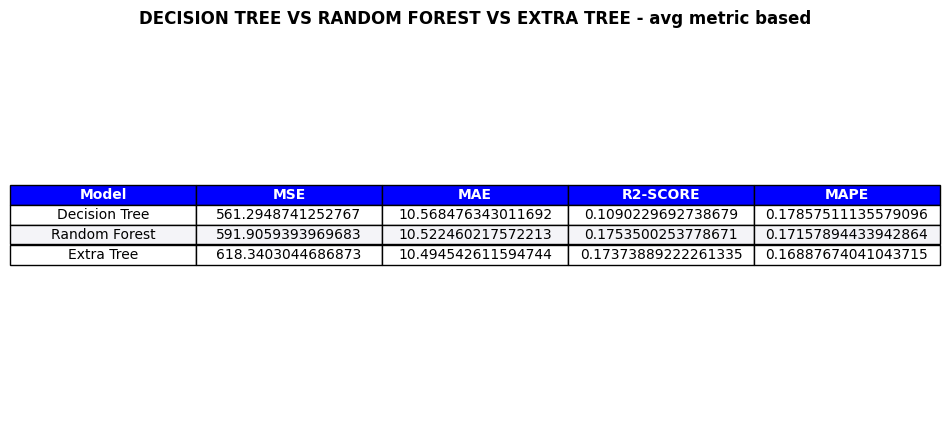

In [ ]:
indexes = ['Decision Tree', 'Random Forest', 'Extra Tree']

avg_metrics1 = {
    'MSE': [tree_mse1.mean(), rf_mse1.mean(), extra_mse1.mean()],
    'MAE': [tree_mae1.mean(), rf_mae1.mean(), extra_mae1.mean()],
    'R2-SCORE': [tree_r21.mean(), rf_r21.mean(), extra_r21.mean()],
    # 'MAPE': [tree_mape1, rf_mape1, extra_mape1]
}
df_avg1 = pd.DataFrame(avg_metrics1)

single_metrics = {
    'MSE' : [tree_mse1, rf_mse1, extra_mse1],
    'MAE' :[tree_mae1, rf_mae1, extra_mae1],
    'R2-SCORE' :[tree_r21, rf_r21, extra_r21]
}

formatted_single_metrics1 = markdown_table(single_metrics)
df_single1 = pd.DataFrame(formatted_single_metrics1,index=indexes)

print(tabulate(df_single1, headers='keys', tablefmt='grid',showindex=True))

fig, axes = plt.subplots(figsize=(10,5))  
create_metric_table(df_avg1, 'DECISION TREE VS RANDOM FOREST VS EXTRA TREE - avg metric based', indexes, axes)
plt.show()


__*CONSIDERATIONS*__

* MSE : Random Forest is able to reach a lower mse, this implies that it is able to better predict the realizations compared to normal Decision trees and Extra trees, Looking at the single mse for the realizations, it is possible to notice that :
    * __EXTRA TREES__ perform better *way better* in predicting weight,weeklyKM,Lactate,vo2max compared to the other models which is something to take into considertion! Some other realization's mse are almost equal to the other models. Though, it is possible to see that it is not able to predict forces stengths better than Random forests...
    * __RANDOM FOREST__ perform better in predicting strengths compared to extra trees even if not that much but still by some units. 
    * __DECISION TREE__ perform worse than boththe others, some realization's mse are close to the others though some metrics are very bad such as mse for weeklyKM compared to random forest and extra trees.

* MAE : All the MAE of the models are almost the same value which means that there is not that big of a difference in terms of averag error for the realizations:
    * __EXTRA TREES__ In this case the difference is really not that much compared to random forest when dealing withrealization's mae, it is possible to see that performs best as said before on weklyKM and days, though by not that much every realization's mae seems to be lower for random forest compared to extra trees. Inthis case it seems as if the strengths are better predicted by extra trees...This implies maybe somebig single values that squared makes the MSE higher for extra trees.
    * __RANDOM FOREST__ As already said for extra trees, random forest in this case performs a little bit better in most of the realizations evenif overall the avg says that mae is lower for extra trees, for most of the realizations the difference in really light which makes both random forest and extra trees a good pick
    * __DECISION TREES__ Always the worst as expected, evenif difference seems not that much by taking a look atsingle realizations, it is possible tosee that it performs worse.

* R2 : this metric is very important because it exemplifies the amount of variance explained by the model. In this case it is very low for all the models which is expected given the small dataset and the multioutput prediction, though by analyzing what we have it is possible to see that :
    * __EXTRA TREES__ have higher R2-score which means that this model is able to capture the most variance, still very close to Random forest. It performs very well in explaining weight,vo2max,anaerobic_maximalPower_W, FFM,bmi. This realizations are the one that have a higher r2. It's r2 scores for weeklyKM,days,pbf are way higher than Random forest.
    * __RANDOM FOREST__  ghave good r2 score for the following realizations : sumStrength,FFM,anaerobic_maximalPower_W, the rest is all lower than extra trees.
    *__DECISION TREE__ performs really good with strength, though the rest of the scores are really really bad... whcich make the model unpickable.

__*Y SPACE REDUCTION*__

Given that some of the R2-scores of the models arealso negative, this means that a simple avg performs best than the model prediction, and given the fact that our models aims to be a simple model and very accessible to recreational runners it is possible to remove some realizations from our analyses that either are not very well predicted by the models or that are too hard for a normal recreational athlete to constantly monitor.

Focusing on __RANDOM FOREST__, it is possible to remove :

- anaerobic_maximalRelPower_W/KG
- bestSar
- relSumStrength
- RPE

Focusing on __EXTRA TREES__ it is possible to remove :

- anaerobic_maximalRelPower_W/KG
- RPE
- bestSar
- bestSJ
- bestLHGStrength
- relSumStrength



In [29]:
y_marathon= y_marathon.drop(columns=['anaerobic_maximalRelPower_W/KG','RPE','bestSar','bestSJ','relSumStrength'])
y_marathon.head()

,weight,bmi,pbf,vo2max,Lactate,anaerobic_maximalVelocity_min,f0_kg,anaerobic_maximalForce_N,anaerobic_maximalPower_W,FFM,bestRHGStrength,bestLHGStrength,trunkStrength,trunkLegsStrength,SumStrength,bestCMJ,days,weeklyKM
0,70.7,23.14,15.6,59.7,15.3,210.7,16.08,157.74,847.01,59.67,53.2,60.7,154.5,212.0,480.4,36.0,6.5,65.0
1,71.7,22.63,10.0,46.7,7.6,205.9,14.50,142.25,746.39,64.53,49.3,50.8,124.8,142.0,366.9,26.6,6.0,110.0
2,66.2,21.87,12.8,62.0,5.7,192.8,14.95,146.66,720.59,57.73,46.9,46.8,109.5,152.0,355.2,24.7,5.0,90.0
3,67.8,20.74,13.7,61.9,10.2,180.5,17.19,168.63,775.70,58.51,48.1,49.1,128.0,134.5,359.7,24.7,5.5,65.0
4,68.3,22.18,12.3,50.2,6.8,188.0,13.43,131.75,631.21,59.90,54.2,51.7,132.0,167.5,405.4,20.7,5.0,12.5


In [ ]:
tree2, tree_train2, tree_mse2, tree_mae2, tree_r22, tree_root2 = perform_tree_regression(DecisionTreeRegressor,X_marathon,y_marathon,False)
rf2, rf_train2, rf_mse2, rf_mae2, rf_r22, rf_root2= perform_tree_regression(RandomForestRegressor,X_marathon,y_marathon,True)
extra2, extra_train2, extra_mse2, extra_mae2, extra_r22, extra_root2 = perform_tree_regression(ExtraTreesRegressor,X_marathon,y_marathon,True)

/home/lamberto/.cache/pypoetry/virtualenvs/assignment-07-spark-1iOGQZrB-py3.10/lib/python3.10/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


The Best Parameters are : {'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 9, 'min_samples_split': 2}
The Best negative MSE Score is : -971.7758006554956


/home/lamberto/.cache/pypoetry/virtualenvs/assignment-07-spark-1iOGQZrB-py3.10/lib/python3.10/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


The Best Parameters are : {'max_depth': 11, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 14, 'n_estimators': 200}
The Best negative MSE Score is : -885.617220648106
The Best Parameters are : {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
The Best negative MSE Score is : -924.3138020572047


+---------------+----------------------------------------------------+----------------------------------------------------+-----------------------------------------------------+
|               | MSE                                                | MAE                                                | R2-SCORE                                            |
+===============+====================================================+====================================================+=====================================================+
| Decision Tree | weight : 71.21440706801555                         | weight : 6.546524504302283                         | weight : 0.3081824586986289                         |
|               | bmi : 6.444136390603849                            | bmi : 1.874818983485649                            | bmi : 0.2083382000757109                            |
|               | pbf : 20.88211913881402                            | pbf : 3.8118315429426537               

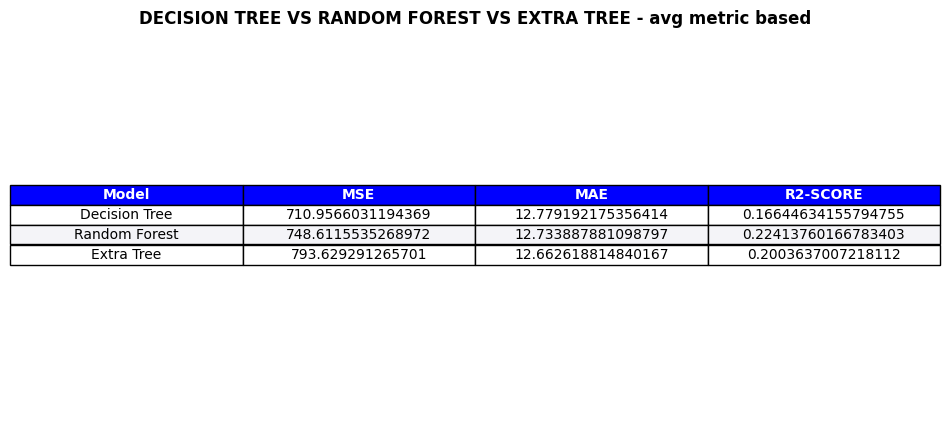

In [ ]:
indexes = ['Decision Tree', 'Random Forest', 'Extra Tree']

avg_metrics2 = {
    'MSE': [tree_mse2.mean(), rf_mse2.mean(), extra_mse2.mean()],
    'MAE': [tree_mae2.mean(), rf_mae2.mean(), extra_mae2.mean()],
    'R2-SCORE': [tree_r22.mean(), rf_r22.mean(), extra_r22.mean()],
    # 'MAPE': [tree_mape2.mean(), rf_mape2.mean(), extra_mape2.mean()]
}
df_avg2 = pd.DataFrame(avg_metrics2)


single_metrics2 = {
    'MSE' : [tree_mse2, rf_mse2, extra_mse2],
    'MAE' :[tree_mae2, rf_mae2, extra_mae2],
    'R2-SCORE' :[tree_r22, rf_r22, extra_r22],
    # 'MAPE': [tree_mape2.mean(), rf_mape2.mean(), extra_mape2.mean()]
}
formatted_single_metrics2 = markdown_table(single_metrics2)
df_single2 = pd.DataFrame(formatted_single_metrics2,index=indexes)


print(tabulate(df_single2, headers='keys', tablefmt='grid',showindex=True))

fig, axes = plt.subplots(figsize=(10,5))  
create_metric_table(df_avg2, 'DECISION TREE VS RANDOM FOREST VS EXTRA TREE - avg metric based', indexes, axes)
plt.show()


In [30]:
y_marathon= y_marathon.drop(columns=['anaerobic_maximalForce_N', 'bestCMJ', 'f0_kg', 'bestLHGStrength', 'bestRHGStrength'])
y_marathon.head()

,weight,bmi,pbf,vo2max,Lactate,anaerobic_maximalVelocity_min,anaerobic_maximalPower_W,FFM,trunkStrength,trunkLegsStrength,SumStrength,days,weeklyKM
0,70.7,23.14,15.6,59.7,15.3,210.7,847.01,59.67,154.5,212.0,480.4,6.5,65.0
1,71.7,22.63,10.0,46.7,7.6,205.9,746.39,64.53,124.8,142.0,366.9,6.0,110.0
2,66.2,21.87,12.8,62.0,5.7,192.8,720.59,57.73,109.5,152.0,355.2,5.0,90.0
3,67.8,20.74,13.7,61.9,10.2,180.5,775.70,58.51,128.0,134.5,359.7,5.5,65.0
4,68.3,22.18,12.3,50.2,6.8,188.0,631.21,59.90,132.0,167.5,405.4,5.0,12.5


In [ ]:
tree3, tree_train3, tree_mse3, tree_mae3, tree_r23, tree_root3 = perform_tree_regression(DecisionTreeRegressor,X_marathon,y_marathon,False)
rf3, rf_train3, rf_mse3, rf_mae3, rf_r23, rf_root3 = perform_tree_regression(RandomForestRegressor,X_marathon,y_marathon,True)
extra3, extra_train3, extra_mse3, extra_mae3, extra_r23, extra_root3 = perform_tree_regression(ExtraTreesRegressor,X_marathon,y_marathon,True)

The Best Parameters are : {'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 9, 'min_samples_split': 2}
The Best negative MSE Score is : -1302.7457769791176


/home/lamberto/.cache/pypoetry/virtualenvs/assignment-07-spark-1iOGQZrB-py3.10/lib/python3.10/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


The Best Parameters are : {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 14, 'n_estimators': 200}
The Best negative MSE Score is : -1181.5427479358314
The Best Parameters are : {'max_depth': 7, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
The Best negative MSE Score is : -1239.928357382441


+---------------+----------------------------------------------------+---------------------------------------------------+-----------------------------------------------------+
|               | MSE                                                | MAE                                               | R2-SCORE                                            |
+===============+====================================================+===================================================+=====================================================+
| Decision Tree | weight : 71.21440706801555                         | weight : 6.546524504302283                        | weight : 0.3081824586986289                         |
|               | bmi : 6.444136390603849                            | bmi : 1.874818983485649                           | bmi : 0.2083382000757109                            |
|               | pbf : 20.88211913881402                            | pbf : 3.8118315429426537                    

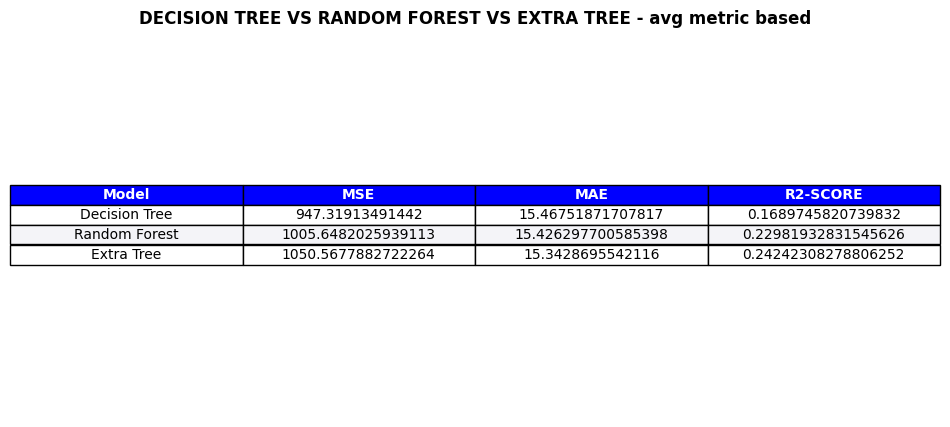

In [ ]:
indexes = ['Decision Tree', 'Random Forest', 'Extra Tree']

avg_metrics3 = {
    'MSE': [tree_mse3.mean(), rf_mse3.mean(), extra_mse3.mean()],
    'MAE': [tree_mae3.mean(), rf_mae3.mean(), extra_mae3.mean()],
    'R2-SCORE': [tree_r23.mean(), rf_r23.mean(), extra_r23.mean()],
    # 'MAPE': [tree_mape3.mean(), rf_mape3.mean(), extra_mape3.mean()]
}

df_avg3 = pd.DataFrame(avg_metrics3)

single_metrics3 = {
    'MSE' : [tree_mse3, rf_mse3, extra_mse3],
    'MAE' :[tree_mae3, rf_mae3, extra_mae3],
    'R2-SCORE' :[tree_r23, rf_r23, extra_r23]
}

formatted_single_metrics3 = markdown_table(single_metrics3)
df_single3 = pd.DataFrame(formatted_single_metrics3,index=indexes)
print(tabulate(df_single3, headers='keys', tablefmt='grid',showindex=True))

fig, axes = plt.subplots(figsize=(10,5))  
create_metric_table(df_avg3, 'DECISION TREE VS RANDOM FOREST VS EXTRA TREE - avg metric based', indexes, axes)
plt.show()

In [31]:
y_marathon= y_marathon.drop(columns=['trunkStrength', 'trunkLegsStrength','SumStrength'])
y_marathon.head()

,weight,bmi,pbf,vo2max,Lactate,anaerobic_maximalVelocity_min,anaerobic_maximalPower_W,FFM,days,weeklyKM
0,70.7,23.14,15.6,59.7,15.3,210.7,847.01,59.67,6.5,65.0
1,71.7,22.63,10.0,46.7,7.6,205.9,746.39,64.53,6.0,110.0
2,66.2,21.87,12.8,62.0,5.7,192.8,720.59,57.73,5.0,90.0
3,67.8,20.74,13.7,61.9,10.2,180.5,775.70,58.51,5.5,65.0
4,68.3,22.18,12.3,50.2,6.8,188.0,631.21,59.90,5.0,12.5


In [ ]:
tree4, tree_train4, tree_mse4, tree_mae4, tree_r24, tree_root4 = perform_tree_regression(DecisionTreeRegressor,X_marathon,y_marathon,False)
rf4, rf_train4, rf_mse4, rf_mae4, rf_r24, rf_root4 = perform_tree_regression(RandomForestRegressor,X_marathon,y_marathon,True)
extra4, extra_train4, extra_mse4, extra_mae4, extra_r24, extra_root4 = perform_tree_regression(ExtraTreesRegressor,X_marathon,y_marathon,True)

/home/lamberto/.cache/pypoetry/virtualenvs/assignment-07-spark-1iOGQZrB-py3.10/lib/python3.10/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


The Best Parameters are : {'max_depth': 6, 'max_features': None, 'min_samples_leaf': 9, 'min_samples_split': 2}
The Best negative MSE Score is : -1291.3413787970626
The Best Parameters are : {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 14, 'n_estimators': 300}
The Best negative MSE Score is : -1102.6623548029092
The Best Parameters are : {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
The Best negative MSE Score is : -1144.5344370791113


+---------------+----------------------------------------------------+----------------------------------------------------+-----------------------------------------------------+
|               | MSE                                                | MAE                                                | R2-SCORE                                            |
+===============+====================================================+====================================================+=====================================================+
| Decision Tree | weight : 73.84822629267258                         | weight : 6.557135457135457                         | weight : 0.28259603011972867                        |
|               | bmi : 6.071722618333166                            | bmi : 1.8887053687053679                           | bmi : 0.2540892114450989                            |
|               | pbf : 17.922829033502683                           | pbf : 3.4776314220758673               

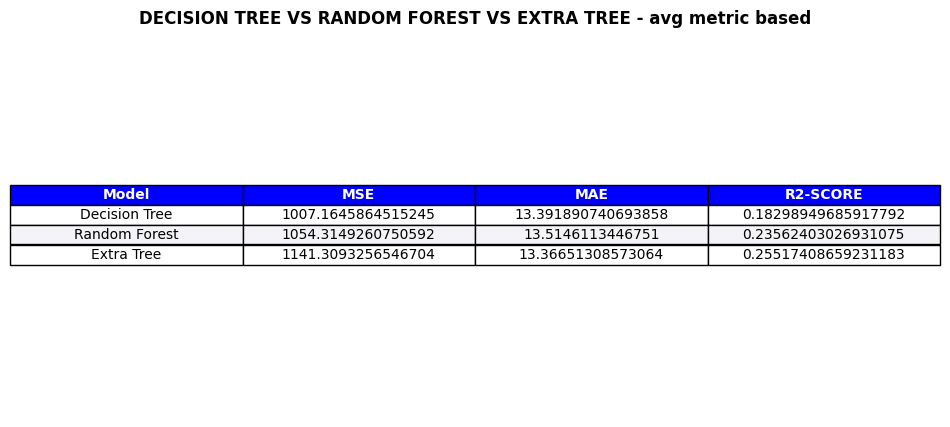

In [ ]:
indexes = ['Decision Tree', 'Random Forest', 'Extra Tree']

avg_metrics4 = {
    'MSE': [tree_mse4.mean(), rf_mse4.mean(), extra_mse4.mean()],
    'MAE': [tree_mae4.mean(), rf_mae4.mean(), extra_mae4.mean()],
    'R2-SCORE': [tree_r24.mean(), rf_r24.mean(), extra_r24.mean()],
    # 'MAPE': [tree_mape4.mean(), rf_mape4.mean(), extra_mape4.mean()]
}

df_avg4 = pd.DataFrame(avg_metrics4)

single_metrics4 = {
    'MSE' : [tree_mse4, rf_mse4, extra_mse4],
    'MAE' :[tree_mae4, rf_mae4, extra_mae4],
    'R2-SCORE' :[tree_r24, rf_r24, extra_r24],
    # 'MAPE': [tree_mape4.mean(), rf_mape4.mean(), extra_mape4.mean()]
}
formatted_single_metrics4 = markdown_table(single_metrics4)
df_single4 = pd.DataFrame(formatted_single_metrics4,index=indexes)

print(tabulate(df_single4, headers='keys', tablefmt='grid',showindex=True))

fig, axes = plt.subplots(figsize=(10,5))  
create_metric_table(df_avg4, 'DECISION TREE VS RANDOM FOREST VS EXTRA TREE - avg metric based', indexes, axes)
plt.show()

## __*PREDONE BEFORE FINDING NEW INPUT SPACES (do not consider anymore)*__

#### __*PREPARE DATA*__

In [136]:
y_marathon = data[['weight', 'days', 'weeklyKM', 'vo2max']] 

#### __*FETURE EXTRACTION*__

In [ ]:
new_dt_features,new_tree = Feature_extraction(DecisionTreeRegressor,X_marathon,y_marathon,gs_dt,False,42)
new_rf_features,new_rf = Feature_extraction(RandomForestRegressor,X_marathon,y_marathon,gs_rf,True,42)
new_extra_features,new_extra = Feature_extraction(ExtraTreesRegressor,X_marathon,y_marathon,gs_extra,True,42)

In [138]:
new_dt_importances = new_tree.feature_importances_
new_rf_importances = new_rf.feature_importances_
new_extra_imporances = new_extra.feature_importances_

new_reg_arr = ['DecisionTreeRegressor', 'RandomForestRegressor', 'ExtraTreesRegressor']
new_imp_arr = [new_dt_importances,new_rf_importances,new_extra_imporances]
                                                                                                                                                                                                                    
for i in range(len(new_imp_arr)):
    print('*' * 200)
    print(f'REGRESSOR : {new_reg_arr[i]} ')
    for j,col in enumerate(X_marathon.columns):
        print(f'importance of {col} : {new_imp_arr[i][j]}')

print('*' * 200)

********************************************************************************************************************************************************************************************************
REGRESSOR : DecisionTreeRegressor 
importance of marathon_time_in_minutes : 0.0
importance of height : 0.08292118910378551
importance of age : 0.36100937150111917
importance of HRmax : 0.0
importance of yearsTrained : 0.0
importance of numHalfMarathon : 0.1861704267603929
importance of numMarathons : 0.3698990126347023
********************************************************************************************************************************************************************************************************
REGRESSOR : RandomForestRegressor 
importance of marathon_time_in_minutes : 0.37143177575006736
importance of height : 0.08379413265976904
importance of age : 0.10306221992306987
importance of HRmax : 0.1355993451820843
importance of yearsTrained : 0.1513476830104837
importanc

In [139]:
new_features_arr = [new_dt_features,new_rf_features,new_extra_features]
new_reg_arr = ['Decision Tree', 'Random Forest', 'Extra tree']

for i,ft in enumerate(new_features_arr):
    print(f'The selected features for model -> {new_reg_arr[i]} are : {ft}')


The selected features for model -> Decision Tree are : Index(['age', 'numHalfMarathon', 'numMarathons'], dtype='object')
The selected features for model -> Random Forest are : Index(['marathon_time_in_minutes', 'yearsTrained'], dtype='object')
The selected features for model -> Extra tree are : Index(['marathon_time_in_minutes', 'yearsTrained'], dtype='object')


Optimal number of features: 7
Selected features: Index(['marathon_time_in_minutes', 'height', 'age', 'HRmax', 'yearsTrained',
       'numHalfMarathon', 'numMarathons'],
      dtype='object')


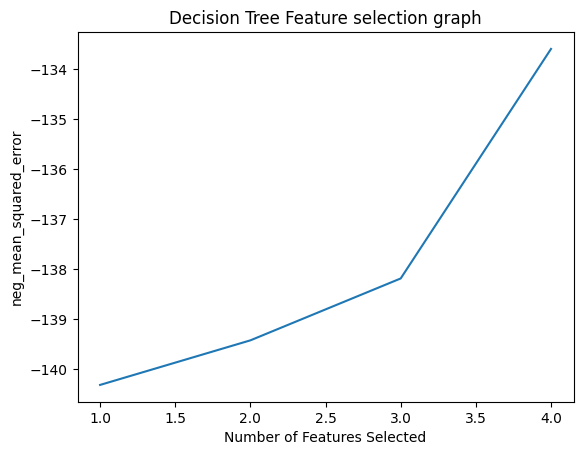

Optimal number of features: 3
Selected features: Index(['marathon_time_in_minutes', 'HRmax', 'yearsTrained'], dtype='object')


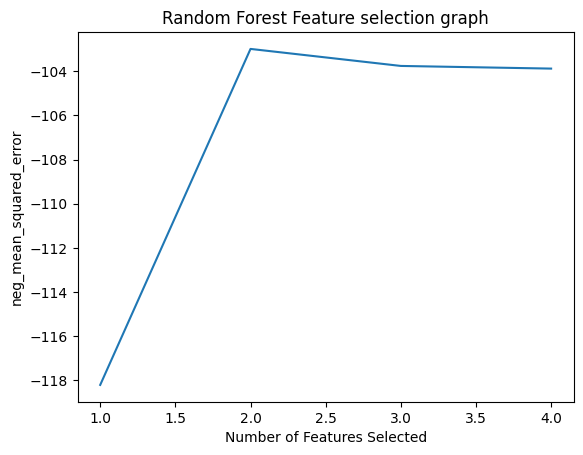

Optimal number of features: 3
Selected features: Index(['marathon_time_in_minutes', 'HRmax', 'yearsTrained'], dtype='object')


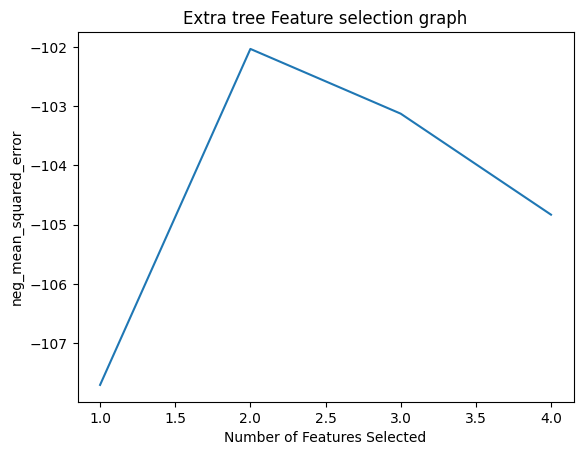

In [140]:
Feature_selection_through_rfecv(DecisionTreeRegressor,X_marathon,y_marathon,False,gs_dt,"Decision Tree Feature selection graph")
Feature_selection_through_rfecv(RandomForestRegressor,X_marathon,y_marathon,True,gs_rf, "Random Forest Feature selection graph")
Feature_selection_through_rfecv(ExtraTreesRegressor,X_marathon,y_marathon,True,gs_extra,"Extra tree Feature selection graph")

#### __*TRAIN AND EVALUATE THE MODEL*__

In [141]:
X_marathon = data[['marathon_time_in_minutes', 'height', 'age', 'yearsTrained']]

In [ ]:
tree5, tree_train5, tree_mse5, tree_mae5, tree_r25,  tree_root_mse5 = perform_tree_regression(DecisionTreeRegressor,X_marathon,y_marathon,False,42)
rf5, rf_train5, rf_mse5, rf_mae5, rf_r25,  rf_root_mse5 = perform_tree_regression(RandomForestRegressor,X_marathon,y_marathon,True,42)
extra5, extra_train5, extra_mse5, extra_mae5, extra_r25, extra_root_mse5 = perform_tree_regression(ExtraTreesRegressor,X_marathon,y_marathon,True,42)

/home/lamberto/.local/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


The Best Parameters are : {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 6, 'min_samples_split': 13}
The Best negative MSE Score is : -114.31214238975058


/home/lamberto/.local/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


The Best Parameters are : {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 11, 'n_estimators': 200}
The Best negative MSE Score is : -97.59099883598681


/home/lamberto/.local/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


The Best Parameters are : {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 100}
The Best negative MSE Score is : -95.60017328464372


+---------------+-------------------------------+-------------------------------+---------------------------------+-------------------------------+
|               | MSE                           | MAE                           | R2-SCORE                        | ROOT MSE                      |
+===============+===============================+===============================+=================================+===============================+
| Decision Tree | weight : 74.54880691711207    | weight : 7.81951530612245     | weight : 0.1697690741869632     | weight : 8.63416509670229     |
|               | days : 1.8338496112730809     | days : 1.0501700680272108     | days : -1.2893918713982409      | days : 1.3541970356167086     |
|               | weeklyKM : 370.21132977000315 | weeklyKM : 14.222789115646256 | weeklyKM : -0.8079675248676783  | weeklyKM : 19.24087653330802  |
|               | vo2max : 74.304851215784      | vo2max : 6.796981292517009    | vo2max : 0.20907124355126427  

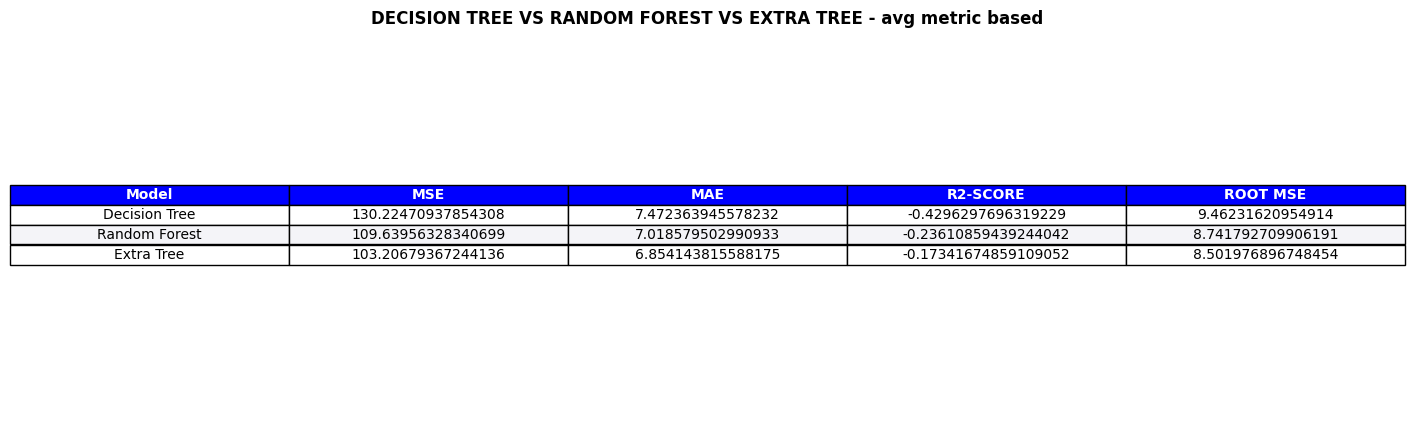

In [146]:
indexes = ['Decision Tree', 'Random Forest', 'Extra Tree']

avg_metrics5 = {
    'MSE': [tree_mse5.mean(), rf_mse5.mean(), extra_mse5.mean()],
    'MAE': [tree_mae5.mean(), rf_mae5.mean(), extra_mae5.mean()],
    'R2-SCORE': [tree_r25.mean(), rf_r25.mean(), extra_r25.mean()],
    # 'MAPE': [tree_mape5, rf_mape5, extra_mape5],
    'ROOT MSE': [tree_root_mse5.mean(), rf_root_mse5.mean(), extra_root_mse5.mean()]

}

df_avg5 = pd.DataFrame(avg_metrics5)

single_metrics5 = {
    'MSE' : [tree_mse5, rf_mse5, extra_mse5],
    'MAE' :[tree_mae5, rf_mae5, extra_mae5],
    'R2-SCORE' :[tree_r25, rf_r25, extra_r25],
    # 'MAPE' :[tree_mape_single5, rf_mape_single5, extra_mape_single5],
    'ROOT MSE ' :[tree_root_mse5, rf_root_mse5, extra_root_mse5]
}
formatted_single_metrics5 = markdown_table(single_metrics5,y_marathon)
df_single5 = pd.DataFrame(formatted_single_metrics5,index=indexes)

print(tabulate(df_single5, headers='keys', tablefmt='grid',showindex=True))

fig, axes = plt.subplots(figsize=(15,5))  
create_metric_table(df_avg5, 'DECISION TREE VS RANDOM FOREST VS EXTRA TREE - avg metric based', indexes, axes)
plt.show()

*ROOT_MSE* : can be seen as the exact amountof error perprediction

In [ ]:
X_marathon = data[['marathon_time_in_minutes', 'height', 'age', 'yearsTrained', 'numHalfMarathon']]
y_marathon = data[['weight', 'vo2max']] 

In [ ]:
tree6, tree_train6, tree_mse6, tree_mae6, tree_r26,  tree_root_mse6 = perform_tree_regression(DecisionTreeRegressor,X_marathon,y_marathon,False,42)
rf6, rf_train6, rf_mse6, rf_mae6, rf_r26,  rf_root_mse6 = perform_tree_regression(RandomForestRegressor,X_marathon,y_marathon,True,42)
extra6, extra_train6, extra_mse6, extra_mae6, extra_r26, extra_root_mse6 = perform_tree_regression(ExtraTreesRegressor,X_marathon,y_marathon,True,42)

/home/lamberto/.local/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


The Best Parameters are : {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 6, 'min_samples_split': 13}
The Best negative MSE Score is : -51.148080104569864


/home/lamberto/.local/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


The Best Parameters are : {'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 9, 'n_estimators': 100}
The Best negative MSE Score is : -47.802358759271065


/home/lamberto/.local/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


The Best Parameters are : {'max_depth': 6, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 14, 'n_estimators': 100}
The Best negative MSE Score is : -47.78218532186371


+---------------+-----------------------------+-----------------------------+------------------------------+----------------------------+
|               | MSE                         | MAE                         | R2-SCORE                     | ROOT MSE                   |
+===============+=============================+=============================+==============================+============================+
| Decision Tree | weight : 75.81111005380988  | weight : 7.353741496598639  | weight : 0.15571112818921495 | weight : 8.706957565867073 |
|               | vo2max : 65.84904135082606  | vo2max : 7.166156462585034  | vo2max : 0.2990780610312712  | vo2max : 8.114742223313446 |
+---------------+-----------------------------+-----------------------------+------------------------------+----------------------------+
| Random Forest | weight : 68.79935453516711  | weight : 6.7967310380286365 | weight : 0.233799249469144   | weight : 8.294537632392002 |
|               | vo2max : 57.7465

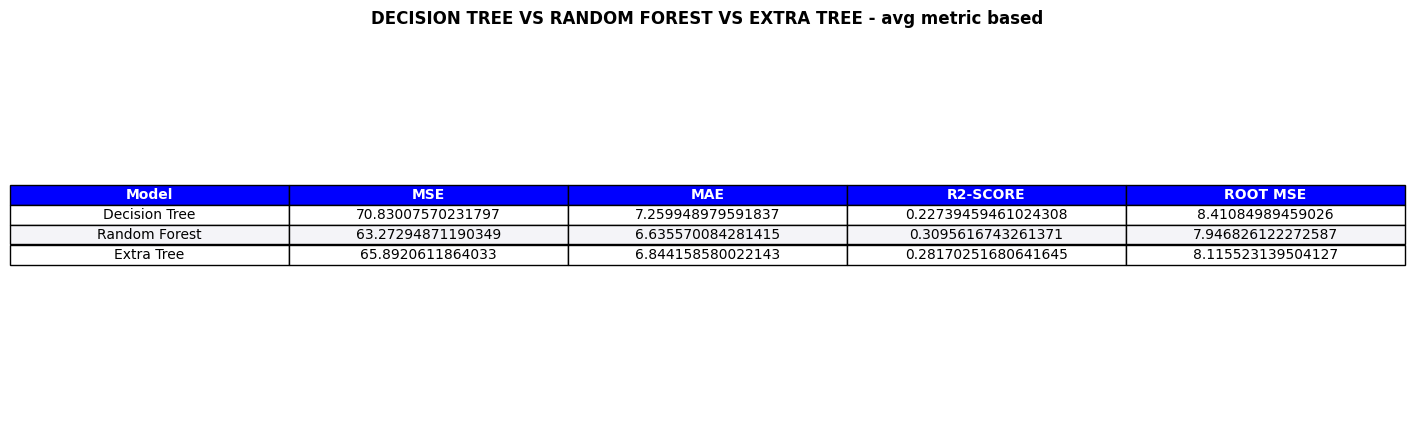

In [14]:
indexes = ['Decision Tree', 'Random Forest', 'Extra Tree']

avg_metrics6 = {
    'MSE': [tree_mse6.mean(), rf_mse6.mean(), extra_mse6.mean()],
    'MAE': [tree_mae6.mean(), rf_mae6.mean(), extra_mae6.mean()],
    'R2-SCORE': [tree_r26.mean(), rf_r26.mean(), extra_r26.mean()],
    # 'MAPE': [tree_mape5, rf_mape5, extra_mape5],
    'ROOT MSE': [tree_root_mse6.mean(), rf_root_mse6.mean(), extra_root_mse6.mean()]

}

df_avg6 = pd.DataFrame(avg_metrics6)

single_metrics6 = {
    'MSE' : [tree_mse6, rf_mse6, extra_mse6],
    'MAE' :[tree_mae6, rf_mae6, extra_mae6],
    'R2-SCORE' :[tree_r26, rf_r26, extra_r26],
    # 'MAPE' :[tree_mape_single5, rf_mape_single5, extra_mape_single5],
    'ROOT MSE ' :[tree_root_mse6, rf_root_mse6, extra_root_mse6]
}
formatted_single_metrics6 = markdown_table(single_metrics6,y_marathon)
df_single6 = pd.DataFrame(formatted_single_metrics6,index=indexes)

print(tabulate(df_single6, headers='keys', tablefmt='grid',showindex=True))

fig, axes = plt.subplots(figsize=(15,5))  
create_metric_table(df_avg6, 'DECISION TREE VS RANDOM FOREST VS EXTRA TREE - avg metric based', indexes, axes)
plt.show()

In [166]:
X_marathon = data[['marathon_time_in_minutes','height','age','HRmax','days','yearsTrained','Halfmarathon_min','FFM', 'bmi']] 
y_marathon = data[['bmi', 'vo2max', 'weight', 'weeklyKM']]

In [ ]:
new_dt_features,new_tree = Feature_extraction(DecisionTreeRegressor,X_marathon,y_marathon,gs_dt,False,42)
new_rf_features,new_rf = Feature_extraction(RandomForestRegressor,X_marathon,y_marathon,gs_rf,True,42)
new_extra_features,new_extra = Feature_extraction(ExtraTreesRegressor,X_marathon,y_marathon,gs_extra,True,42)

In [168]:
new_dt_importances = new_tree.feature_importances_
new_rf_importances = new_rf.feature_importances_
new_extra_imporances = new_extra.feature_importances_

new_reg_arr = ['DecisionTreeRegressor', 'RandomForestRegressor', 'ExtraTreesRegressor']
new_imp_arr = [new_dt_importances,new_rf_importances,new_extra_imporances]
                                                                                                                                                                                                                    
for i in range(len(new_imp_arr)):
    print('*' * 200)
    print(f'REGRESSOR : {new_reg_arr[i]} ')
    for j,col in enumerate(X_marathon.columns):
        print(f'importance of {col} : {new_imp_arr[i][j]}')

print('*' * 200)

********************************************************************************************************************************************************************************************************
REGRESSOR : DecisionTreeRegressor 
importance of marathon_time_in_minutes : 0.11941688695260497
importance of height : 0.05406541938420799
importance of age : 0.0
importance of HRmax : 0.00803694803661456
importance of days : 0.6012221538382247
importance of yearsTrained : 0.0
importance of Halfmarathon_min : 0.0
importance of FFM : 0.12039232214213584
importance of bmi : 0.09686626964621194
********************************************************************************************************************************************************************************************************
REGRESSOR : RandomForestRegressor 
importance of marathon_time_in_minutes : 0.16496774890976212
importance of height : 0.027898750469618906
importance of age : 0.020344469030216705
importance of HRmax : 

In [169]:
new_features_arr = [new_dt_features,new_rf_features,new_extra_features]
new_reg_arr = ['Decision Tree', 'Random Forest', 'Extra tree']

for i,ft in enumerate(new_features_arr):
    print(f'The selected features for model -> {new_reg_arr[i]} are : {ft}')


The selected features for model -> Decision Tree are : Index(['marathon_time_in_minutes', 'days', 'FFM'], dtype='object')
The selected features for model -> Random Forest are : Index(['marathon_time_in_minutes', 'days', 'Halfmarathon_min', 'FFM', 'bmi'], dtype='object')
The selected features for model -> Extra tree are : Index(['days'], dtype='object')


Optimal number of features: 1
Selected features: Index(['days'], dtype='object')


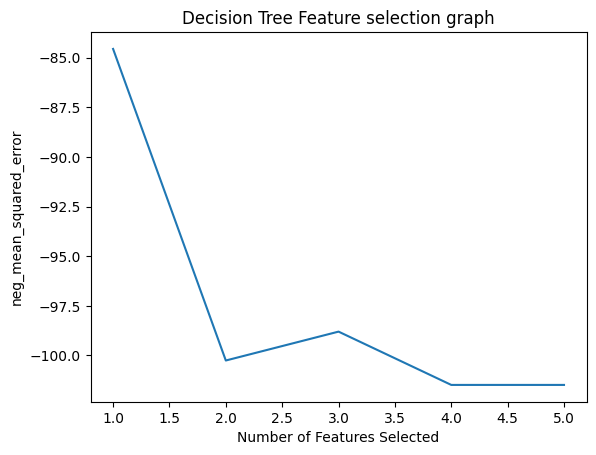

Optimal number of features: 5
Selected features: Index(['marathon_time_in_minutes', 'days', 'Halfmarathon_min', 'FFM', 'bmi'], dtype='object')


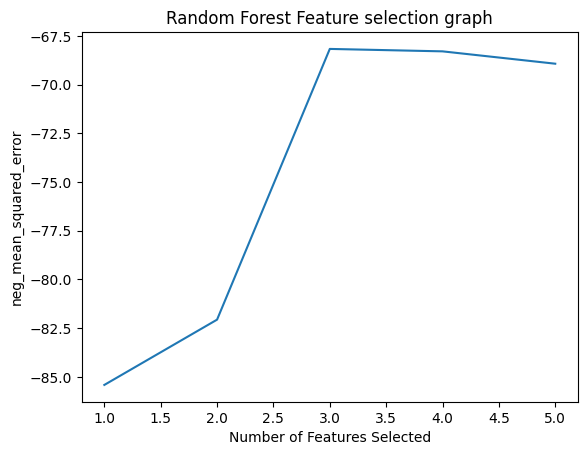

Optimal number of features: 5
Selected features: Index(['marathon_time_in_minutes', 'days', 'Halfmarathon_min', 'FFM', 'bmi'], dtype='object')


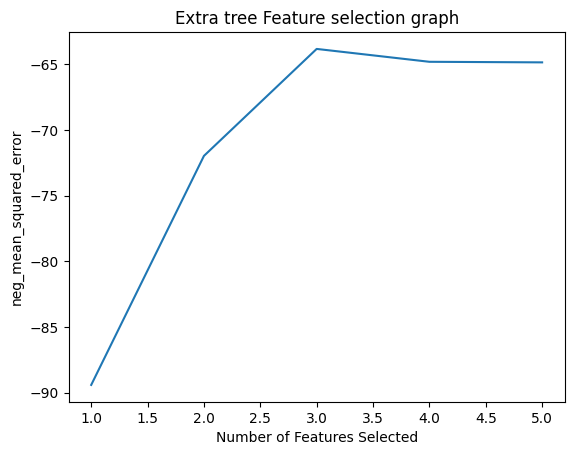

In [ ]:
Feature_selection_through_rfecv(DecisionTreeRegressor,X_marathon,y_marathon,False,gs_dt,"Decision Tree Feature selection graph",42)
Feature_selection_through_rfecv(RandomForestRegressor,X_marathon,y_marathon,True,gs_rf, "Random Forest Feature selection graph",42)
Feature_selection_through_rfecv(ExtraTreesRegressor,X_marathon,y_marathon,True,gs_extra,"Extra tree Feature selection graph",42)

- WHAT WE I SHOWN IS THAT THE MOST INFLUENTIAL PREDICTORS ARE :

    - days
    - Halfmarathon_min
    - FFM 
    - BMI

Given that vo2max has a correlation with age due to its maximal value decreasing with age and we will add it!

It is a known pattern also for height and weight so height will be added!

BMI is already somehow integrated into FFM so we will keep just that that seem to be more influential

From exploratory analysis also HRmax seemed to have some good relations so we will also keep it!

## __NEW X INPUT SPACE__

In [ ]:
X_marathon = data[['marathon_time_in_minutes', 'height', 'age', 'HRmax', 'days', 'Halfmarathon_min', 'FFM']]
y_marathon = data[['bmi', 'vo2max', 'weight', 'weeklyKM']]

In [105]:
tree12, tree_train12, tree_mse12, tree_mae12, tree_r212,  tree_root_mse12 = perform_tree_regression(DecisionTreeRegressor,X_marathon,y_marathon,False)
rf12, rf_train12, rf_mse12, rf_mae12, rf_r212, rf_root_mse12 = perform_tree_regression(RandomForestRegressor,X_marathon,y_marathon,True)
extra12, extra_train12, extra_mse12, extra_mae12, extra_r212, extra_root_mse12 = perform_tree_regression(ExtraTreesRegressor,X_marathon,y_marathon,True)

The Best Parameters are : {'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 11}
The Best negative MSE Score is : -92.292795939858
The Best Parameters are : {'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 100}
The Best negative MSE Score is : -67.1039582093223
The Best Parameters are : {'max_depth': 8, 'max_features': 0.5, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
The Best negative MSE Score is : -64.95730425903969


+---------------+-------------------------------+-------------------------------+--------------------------------+-------------------------------+
|               | MSE                           | MAE                           | R2-SCORE                       | ROOT MSE                      |
+===============+===============================+===============================+================================+===============================+
| Decision Tree | bmi : 9.153645283681788       | bmi : 2.3466930272108835      | bmi : 0.1048886001158229       | bmi : 3.0254991792565056      |
|               | vo2max : 51.40701828017581    | vo2max : 5.715110544217686    | vo2max : 0.45280438119711963   | vo2max : 7.1698687770541385   |
|               | weight : 32.67766789763521    | weight : 4.195374149659863    | weight : 0.6360772010445528    | weight : 5.716438392708803    |
|               | weeklyKM : 325.5619724741749  | weeklyKM : 13.454365079365077 | weeklyKM : -0.5899175044989822 | wee

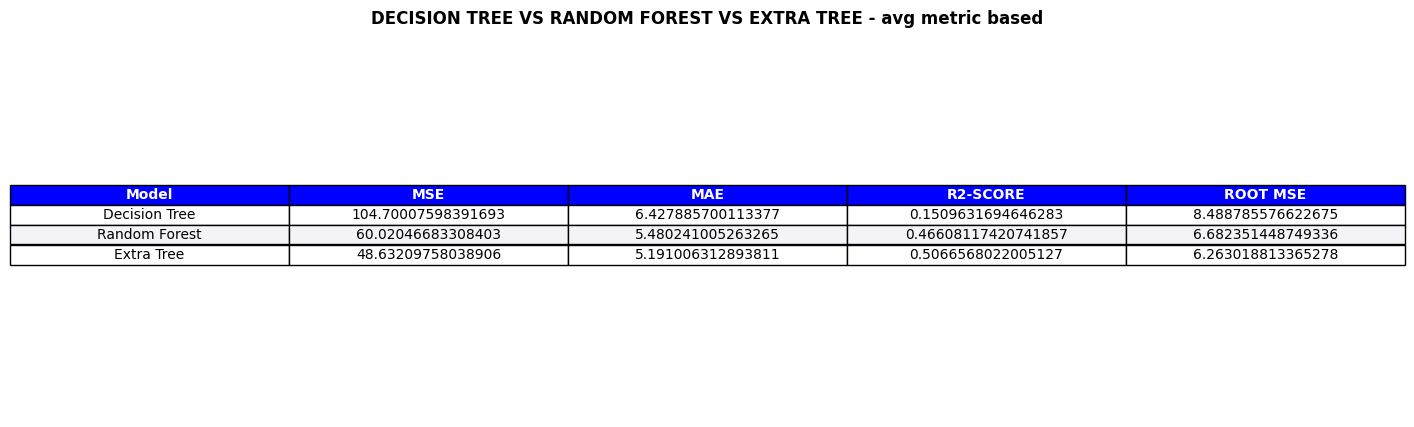

In [107]:
indexes = ['Decision Tree', 'Random Forest', 'Extra Tree']

avg_metrics12 = {
    'MSE': [tree_mse12.mean(), rf_mse12.mean(), extra_mse12.mean()],
    'MAE': [tree_mae12.mean(), rf_mae12.mean(), extra_mae12.mean()],
    'R2-SCORE': [tree_r212.mean(), rf_r212.mean(), extra_r212.mean()],
    'ROOT MSE': [tree_root_mse12.mean(), rf_root_mse12.mean(), extra_root_mse12.mean()]
}

df_avg12 = pd.DataFrame(avg_metrics12)

single_metrics12 = {
    'MSE' : [tree_mse12, rf_mse12, extra_mse12],
    'MAE' :[tree_mae12, rf_mae12, extra_mae12],
    'R2-SCORE' :[tree_r212, rf_r212, extra_r212],
    'ROOT MSE ' :[tree_root_mse12, rf_root_mse12, extra_root_mse12]
}
formatted_single_metrics12 = markdown_table(single_metrics12,y_marathon)
df_single12 = pd.DataFrame(formatted_single_metrics12,index=indexes)

print(tabulate(df_single12, headers='keys', tablefmt='grid',showindex=True))

fig, axes = plt.subplots(figsize=(15,5))  
create_metric_table(df_avg12, 'DECISION TREE VS RANDOM FOREST VS EXTRA TREE - avg metric based', indexes, axes)
plt.show()

## __ADDING YEARSTRAINED TO PREDICTORS AND TRAINED MODEL__

In [123]:
X_marathon = data[['marathon_time_in_minutes', 'height', 'age', 'HRmax', 'days', 'Halfmarathon_min', 'FFM', 'yearsTrained']]
y_marathon = data[['bmi', 'vo2max', 'weight', 'weeklyKM']]

In [124]:
tree14, tree_train14, tree_mse14, tree_mae14, tree_r214,  tree_root_mse14 = perform_tree_regression(DecisionTreeRegressor,X_marathon,y_marathon,False)
rf14, rf_train14, rf_mse14, rf_mae14, rf_r214, rf_root_mse14 = perform_tree_regression(RandomForestRegressor,X_marathon,y_marathon,True)
extra14, extra_train14, extra_mse14, extra_mae14, extra_r214, extra_root_mse14 = perform_tree_regression(ExtraTreesRegressor,X_marathon,y_marathon,True)

The Best Parameters are : {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 5}
The Best negative MSE Score is : -87.96563940233561


/home/lamberto/.local/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


The Best Parameters are : {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 100}
The Best negative MSE Score is : -68.31347466523229


/home/lamberto/.local/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


The Best Parameters are : {'max_depth': 8, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 100}
The Best negative MSE Score is : -65.57352310036376


+---------------+-------------------------------+-------------------------------+--------------------------------+-------------------------------+
|               | MSE                           | MAE                           | R2-SCORE                       | ROOT MSE                      |
+===============+===============================+===============================+================================+===============================+
| Decision Tree | bmi : 8.224767261904761       | bmi : 2.0572619047619045      | bmi : 0.1957211898248329       | bmi : 2.8678855036254083      |
|               | vo2max : 45.390679563492036   | vo2max : 5.567261904761902    | vo2max : 0.5168445511416397    | vo2max : 6.737260538489812    |
|               | weight : 44.7051388888889     | weight : 4.6488095238095255   | weight : 0.5021303440900133    | weight : 6.686190162483332    |
|               | weeklyKM : 378.7521081349206  | weeklyKM : 15.901785714285714 | weeklyKM : -0.8496773502543198 | wee

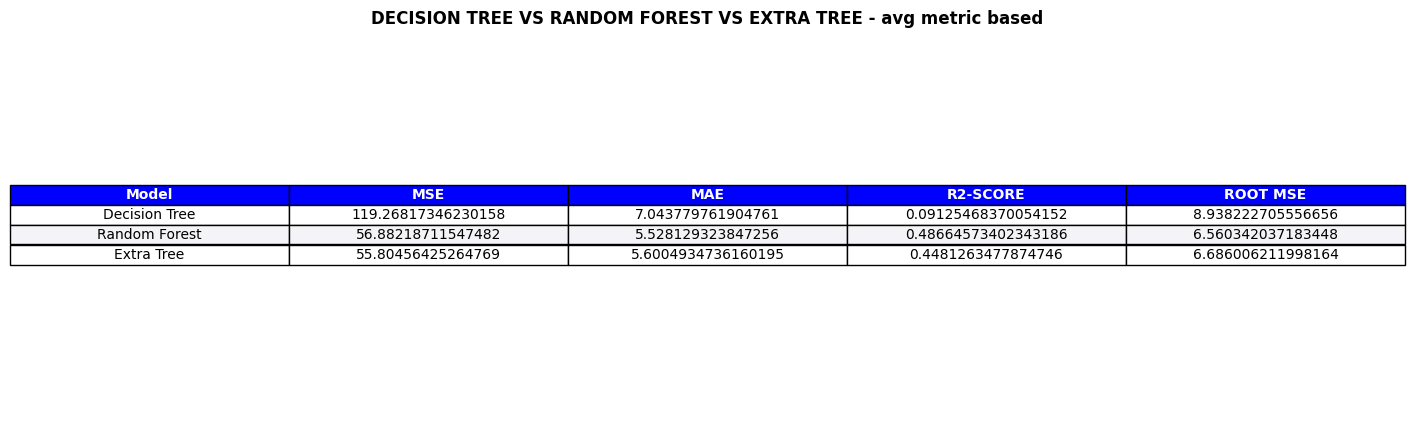

In [125]:
indexes = ['Decision Tree', 'Random Forest', 'Extra Tree']

avg_metrics14 = {
    'MSE': [tree_mse14.mean(), rf_mse14.mean(), extra_mse14.mean()],
    'MAE': [tree_mae14.mean(), rf_mae14.mean(), extra_mae14.mean()],
    'R2-SCORE': [tree_r214.mean(), rf_r214.mean(), extra_r214.mean()],
    'ROOT MSE': [tree_root_mse14.mean(), rf_root_mse14.mean(), extra_root_mse14.mean()]
}

df_avg14 = pd.DataFrame(avg_metrics14)

single_metrics14 = {
    'MSE' : [tree_mse14, rf_mse14, extra_mse14],
    'MAE' :[tree_mae14, rf_mae14, extra_mae14],
    'R2-SCORE' :[tree_r214, rf_r214, extra_r214],
    'ROOT MSE ' :[tree_root_mse14, rf_root_mse14, extra_root_mse14]
}
formatted_single_metrics14 = markdown_table(single_metrics14,y_marathon)
df_single14 = pd.DataFrame(formatted_single_metrics14,index=indexes)

print(tabulate(df_single14, headers='keys', tablefmt='grid',showindex=True))

fig, axes = plt.subplots(figsize=(15,5))  
create_metric_table(df_avg14, 'DECISION TREE VS RANDOM FOREST VS EXTRA TREE - avg metric based', indexes, axes)
plt.show()

## __NEW MODEL WITH NEW INPUT SPACE__

In [19]:
X_marathon = data[['marathon_time_in_minutes', 'height', 'age', 'HRmax', 'days', 'Halfmarathon_min', 'FFM']]
y_marathon = data[['vo2max', 'weight', 'weeklyKM']]

In [13]:
tree15, tree_train15, tree_mse15, tree_mae15, tree_r215,  tree_root_mse15 = perform_tree_regression(DecisionTreeRegressor,X_marathon,y_marathon,False)
rf15, rf_train15, rf_mse15, rf_mae15, rf_r215, rf_root_mse15 = perform_tree_regression(RandomForestRegressor,X_marathon,y_marathon,True)
extra15, extra_train15, extra_mse15, extra_mae15, extra_r215, extra_root_mse15 = perform_tree_regression(ExtraTreesRegressor,X_marathon,y_marathon,True)

/home/lamberto/.local/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


The Best Parameters are : {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 2}
The Best negative MSE Score is : -121.10852243231659
The Best Parameters are : {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 100}
The Best negative MSE Score is : -89.0188124609704
The Best Parameters are : {'max_depth': 8, 'max_features': 0.5, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
The Best negative MSE Score is : -85.33280557664983


+---------------+-------------------------------+-------------------------------+--------------------------------+-------------------------------+
|               | MSE                           | MAE                           | R2-SCORE                       | ROOT MSE                      |
+===============+===============================+===============================+================================+===============================+
| Decision Tree | vo2max : 66.13753850543445    | vo2max : 6.311565934065932    | vo2max : 0.2960071889145802    | vo2max : 8.132498909033709    |
|               | weight : 14.62262330200924    | weight : 2.9401026949241253   | weight : 0.8371515979411907    | weight : 3.8239538833528366   |
|               | weeklyKM : 333.1416607840226  | weeklyKM : 13.737953514739232 | weeklyKM : -0.6269337414718956 | weeklyKM : 18.25216865975171  |
+---------------+-------------------------------+-------------------------------+--------------------------------+----

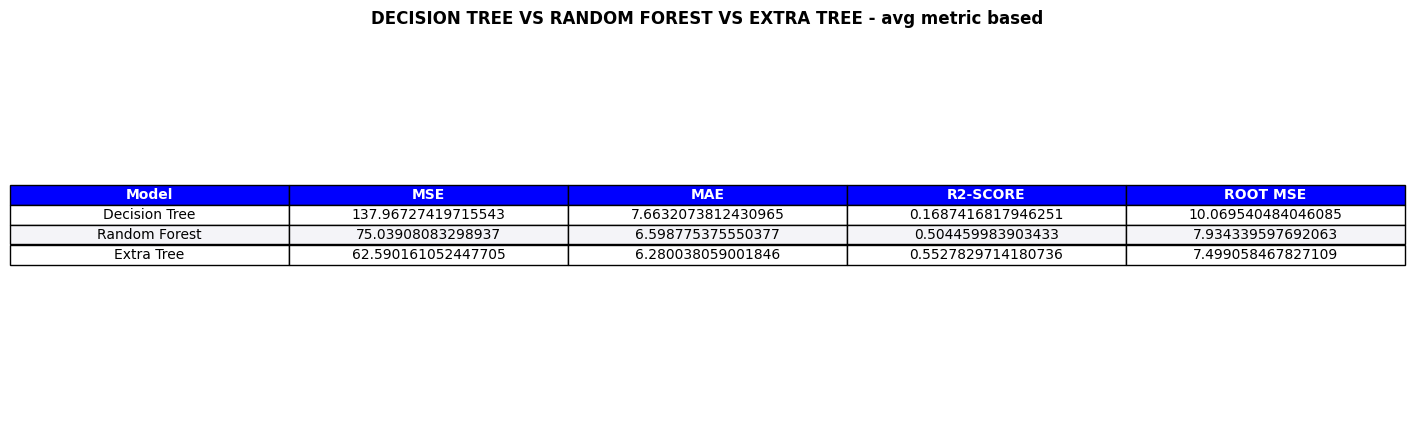

In [14]:
indexes = ['Decision Tree', 'Random Forest', 'Extra Tree']

avg_metrics15 = {
    'MSE': [tree_mse15.mean(), rf_mse15.mean(), extra_mse15.mean()],
    'MAE': [tree_mae15.mean(), rf_mae15.mean(), extra_mae15.mean()],
    'R2-SCORE': [tree_r215.mean(), rf_r215.mean(), extra_r215.mean()],
    'ROOT MSE': [tree_root_mse15.mean(), rf_root_mse15.mean(), extra_root_mse15.mean()]
}

df_avg15 = pd.DataFrame(avg_metrics15)

single_metrics15 = {
    'MSE' : [tree_mse15, rf_mse15, extra_mse15],
    'MAE' :[tree_mae15, rf_mae15, extra_mae15],
    'R2-SCORE' :[tree_r215, rf_r215, extra_r215],
    'ROOT MSE ' :[tree_root_mse15, rf_root_mse15, extra_root_mse15]
}
formatted_single_metrics15 = markdown_table(single_metrics15,y_marathon)
df_single15 = pd.DataFrame(formatted_single_metrics15,index=indexes)

print(tabulate(df_single15, headers='keys', tablefmt='grid',showindex=True))

fig, axes = plt.subplots(figsize=(15,5))  
create_metric_table(df_avg15, 'DECISION TREE VS RANDOM FOREST VS EXTRA TREE - avg metric based', indexes, axes)
plt.show()

## __LAST VALID INPUT SPACE,__

X = 'marathon_time_in_minutes', 'height', 'age', 'HRmax', 'days', 'FFM'

y = 'vo2max', 'weight', 'weeklyKM'

In [43]:
X_marathon = data[['marathon_time_in_minutes', 'height', 'age', 'HRmax', 'days', 'FFM']]
y_marathon = data[['vo2max', 'weight', 'weeklyKM']]

## __LAST MODEL WITH SEED=42__

In [159]:
tree17, tree_train17, tree_mse17, tree_mae17, tree_r217,  tree_root_mse17 = perform_tree_regression(DecisionTreeRegressor,X_marathon,y_marathon,False,42)
rf17, rf_train17, rf_mse17, rf_mae17, rf_r217, rf_root_mse17 = perform_tree_regression(RandomForestRegressor,X_marathon,y_marathon,True,42)
extra17, extra_train17, extra_mse17, extra_mae17, extra_r217, extra_root_mse17 = perform_tree_regression(ExtraTreesRegressor,X_marathon,y_marathon,True,42)

     marathon_time_in_minutes  height  age  HRmax  days    FFM
65                      320.0   180.5   47  156.0     3  72.95
128                     308.0   173.5   54  161.0     3  62.20
30                      225.0   183.5   49  171.0     4  67.69
50                      210.0   166.1   67  167.0     6  58.15
70                      183.0   171.5   42  188.0     6  53.28
..                        ...     ...  ...    ...   ...    ...
114                     240.0   173.5   62  184.0     4  55.71
46                      303.0   183.0   58  166.0     4  65.18
122                     255.0   170.8   48  177.0     4  63.28
126                     285.0   181.5   45  169.0     4  68.28
14                      214.0   181.7   39  181.0     6  65.12

[91 rows x 6 columns]
     marathon_time_in_minutes  height  age  HRmax  days    FFM
71                      179.0   172.4   29  184.0     3  62.75
93                      225.0   180.8   51  170.0     5  67.53
117                     267.0   

/home/lamberto/.local/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


The Best Parameters are : {'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 9}
The Best negative MSE Score is : -113.32688853102222
     marathon_time_in_minutes  height  age  HRmax  days    FFM
65                      320.0   180.5   47  156.0     3  72.95
128                     308.0   173.5   54  161.0     3  62.20
30                      225.0   183.5   49  171.0     4  67.69
50                      210.0   166.1   67  167.0     6  58.15
70                      183.0   171.5   42  188.0     6  53.28
..                        ...     ...  ...    ...   ...    ...
114                     240.0   173.5   62  184.0     4  55.71
46                      303.0   183.0   58  166.0     4  65.18
122                     255.0   170.8   48  177.0     4  63.28
126                     285.0   181.5   45  169.0     4  68.28
14                      214.0   181.7   39  181.0     6  65.12

[91 rows x 6 columns]
     marathon_time_in_minutes  height  age  HRmax  day

/home/lamberto/.local/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


The Best Parameters are : {'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
The Best negative MSE Score is : -90.08723318426267
     marathon_time_in_minutes  height  age  HRmax  days    FFM
65                      320.0   180.5   47  156.0     3  72.95
128                     308.0   173.5   54  161.0     3  62.20
30                      225.0   183.5   49  171.0     4  67.69
50                      210.0   166.1   67  167.0     6  58.15
70                      183.0   171.5   42  188.0     6  53.28
..                        ...     ...  ...    ...   ...    ...
114                     240.0   173.5   62  184.0     4  55.71
46                      303.0   183.0   58  166.0     4  65.18
122                     255.0   170.8   48  177.0     4  63.28
126                     285.0   181.5   45  169.0     4  68.28
14                      214.0   181.7   39  181.0     6  65.12

[91 rows x 6 columns]
     marathon_time_in_minutes  hei

+---------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+
|               | MSE                           | MAE                           | R2-SCORE                      | ROOT MSE                      |
+===============+===============================+===============================+===============================+===============================+
| Decision Tree | vo2max : 58.20769246031747    | vo2max : 5.894761904761906    | vo2max : 0.3804154498648693   | vo2max : 7.629396598704085    |
|               | weight : 19.26271676587303    | weight : 3.7164285714285716   | weight : 0.7854760681551012   | weight : 4.388931164403587    |
|               | weeklyKM : 174.6773611111111  | weeklyKM : 11.210714285714287 | weeklyKM : 0.1469439997563734 | weeklyKM : 13.216556325726877 |
+---------------+-------------------------------+-------------------------------+-------------------------------+-----------

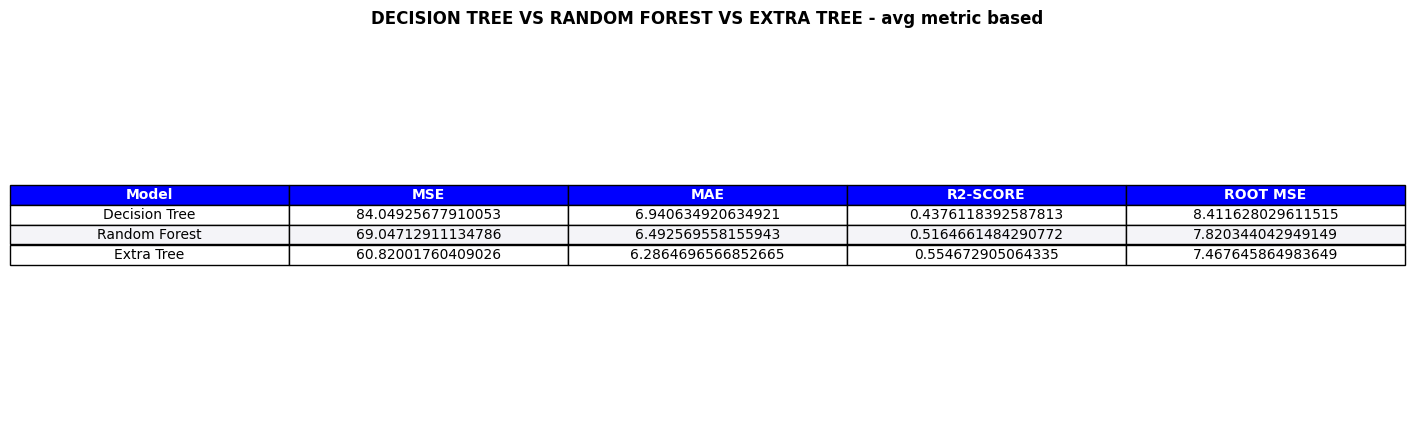

In [161]:
indexes = ['Decision Tree', 'Random Forest', 'Extra Tree']

avg_metrics17 = {
    'MSE': [tree_mse17.mean(), rf_mse17.mean(), extra_mse17.mean()],
    'MAE': [tree_mae17.mean(), rf_mae17.mean(), extra_mae17.mean()],
    'R2-SCORE': [tree_r217.mean(), rf_r217.mean(), extra_r217.mean()],
    'ROOT MSE': [tree_root_mse17.mean(), rf_root_mse17.mean(), extra_root_mse17.mean()]
}

df_avg17 = pd.DataFrame(avg_metrics17)

single_metrics17 = {
    'MSE' : [tree_mse17, rf_mse17, extra_mse17],
    'MAE' :[tree_mae17, rf_mae17, extra_mae17],
    'R2-SCORE' :[tree_r217, rf_r217, extra_r217],
    'ROOT MSE ' :[tree_root_mse17, rf_root_mse17, extra_root_mse17]
}
formatted_single_metrics17 = markdown_table(single_metrics17,y_marathon)
df_single17 = pd.DataFrame(formatted_single_metrics17,index=indexes)

print(tabulate(df_single17, headers='keys', tablefmt='grid',showindex=True))

fig, axes = plt.subplots(figsize=(15,5))  
create_metric_table(df_avg17, 'DECISION TREE VS RANDOM FOREST VS EXTRA TREE - avg metric based', indexes, axes)
plt.show()

## __LAST MODEL WITH SEED=20__

In [28]:
tree18, tree_train18, tree_mse18, tree_mae18, tree_r218,  tree_root_mse18 = perform_tree_regression(DecisionTreeRegressor,X_marathon,y_marathon,False,20)
rf18, rf_train18, rf_mse18, rf_mae18, rf_r218, rf_root_mse18 = perform_tree_regression(RandomForestRegressor,X_marathon,y_marathon,True,20)
extra18, extra_train18, extra_mse18, extra_mae18, extra_r218, extra_root_mse18 = perform_tree_regression(ExtraTreesRegressor,X_marathon,y_marathon,True,20)

/home/lamberto/.local/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


The Best Parameters are : {'max_depth': 5, 'max_features': 0.5, 'min_samples_leaf': 8, 'min_samples_split': 2}
The Best negative MSE Score is : -129.91127431096632


/home/lamberto/.local/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


The Best Parameters are : {'max_depth': 8, 'max_features': 0.5, 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 200}
The Best negative MSE Score is : -110.78699236871562


/home/lamberto/.local/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


The Best Parameters are : {'max_depth': 11, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 200}
The Best negative MSE Score is : -104.6795635862529


### __LOOKING AT SINGLE SETS OF VALIDATION__

In [56]:
t, tree_tr, tree_m, tree_m, tree_,  tree_t_mse18 = perform_tree_regression(DecisionTreeRegressor,X_marathon,y_marathon,False,20)

     marathon_time_in_minutes  height  age  HRmax  days    FFM
98                      225.0   172.5   32  183.0     5  48.93
90                      221.0   175.8   50  166.0     1  70.54
24                      215.0   169.0   38  200.0     3  57.29
62                      293.0   170.9   45  165.0     7  76.17
110                     253.0   176.1   48  189.0     5  63.30
..                        ...     ...  ...    ...   ...    ...
75                      194.0   163.2   59  158.0     5  59.52
87                      205.0   184.5   45  183.0     4  65.85
127                     390.0   170.2   41  188.0     5  56.62
104                     238.0   185.6   41  174.0     4  62.52
35                      243.0   177.1   39  175.0     3  55.88

[91 rows x 6 columns]
     marathon_time_in_minutes  height  age  HRmax  days    FFM
63                      320.0   180.7   49  168.0     3  73.10
131                     300.0   175.8   60  160.0     2  60.74
52                      252.0   

/home/lamberto/.local/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


+---------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+
|               | MSE                           | MAE                           | R2-SCORE                      | ROOT MSE                      |
+===============+===============================+===============================+===============================+===============================+
| Decision Tree | vo2max : 21.341911777041698   | vo2max : 3.590093795093796    | vo2max : 0.6534473944190419   | vo2max : 4.619730703952525    |
|               | weight : 34.63313462629541    | weight : 4.864632034632035    | weight : 0.7631545647326454   | weight : 5.88499232168534     |
|               | weeklyKM : 347.885053899429   | weeklyKM : 13.250993867243867 | weeklyKM : 0.2665542036282744 | weeklyKM : 18.651676972846946 |
+---------------+-------------------------------+-------------------------------+-------------------------------+-----------

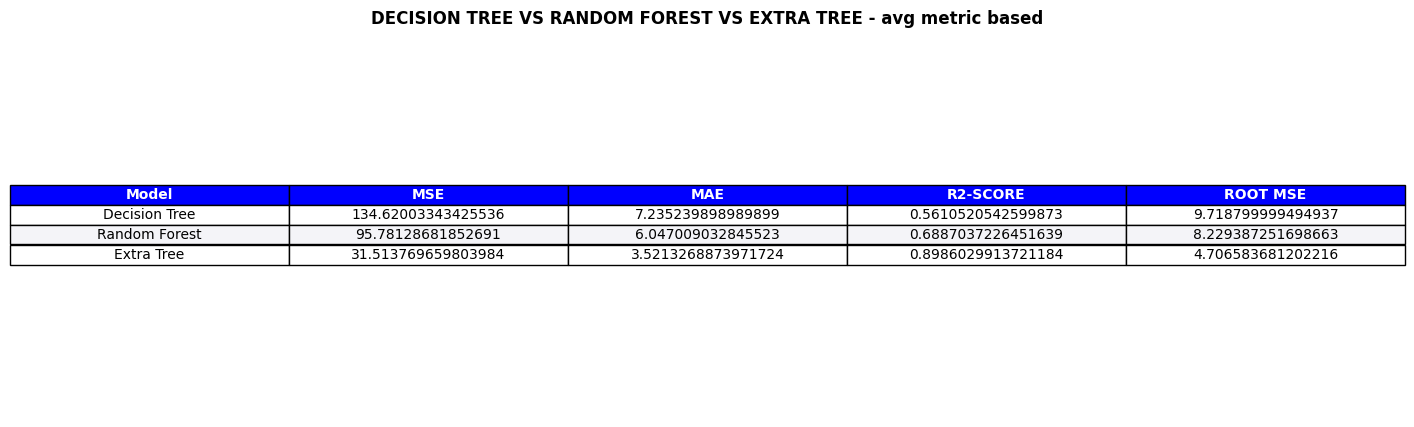

In [30]:
indexes = ['Decision Tree', 'Random Forest', 'Extra Tree']

avg_metrics18 = {
    'MSE': [tree_mse18.mean(), rf_mse18.mean(), extra_mse18.mean()],
    'MAE': [tree_mae18.mean(), rf_mae18.mean(), extra_mae18.mean()],
    'R2-SCORE': [tree_r218.mean(), rf_r218.mean(), extra_r218.mean()],
    'ROOT MSE': [tree_root_mse18.mean(), rf_root_mse18.mean(), extra_root_mse18.mean()]
}

df_avg18 = pd.DataFrame(avg_metrics18)

single_metrics18 = {
    'MSE' : [tree_mse18, rf_mse18, extra_mse18],
    'MAE' :[tree_mae18, rf_mae18, extra_mae18],
    'R2-SCORE' :[tree_r218, rf_r218, extra_r218],
    'ROOT MSE ' :[tree_root_mse18, rf_root_mse18, extra_root_mse18]
}
formatted_single_metrics18 = markdown_table(single_metrics18,y_marathon)
df_single18 = pd.DataFrame(formatted_single_metrics18,index=indexes)

print(tabulate(df_single18, headers='keys', tablefmt='grid',showindex=True))

fig, axes = plt.subplots(figsize=(15,5))  
create_metric_table(df_avg18, 'DECISION TREE VS RANDOM FOREST VS EXTRA TREE - avg metric based', indexes, axes)
plt.show()

## __LAST MODEL WITH SEED=35__

In [29]:
tree19, tree_train19, tree_mse19, tree_mae19, tree_r219,  tree_root_mse19 = perform_tree_regression(DecisionTreeRegressor,X_marathon,y_marathon,False,35)
rf19, rf_train19, rf_mse19, rf_mae19, rf_r219, rf_root_mse19 = perform_tree_regression(RandomForestRegressor,X_marathon,y_marathon,True,35)
extra19, extra_train19, extra_mse19, extra_mae19, extra_r219, extra_root_mse19 = perform_tree_regression(ExtraTreesRegressor,X_marathon,y_marathon,True,35)

The Best Parameters are : {'max_depth': 6, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 13}
The Best negative MSE Score is : -109.42762651872386


/home/lamberto/.local/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


The Best Parameters are : {'max_depth': 9, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 7, 'n_estimators': 100}
The Best negative MSE Score is : -90.18827071931214
The Best Parameters are : {'max_depth': 7, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
The Best negative MSE Score is : -87.7271208218144


+---------------+-------------------------------+------------------------------+-------------------------------+-------------------------------+
|               | MSE                           | MAE                          | R2-SCORE                      | ROOT MSE                      |
+===============+===============================+==============================+===============================+===============================+
| Decision Tree | vo2max : 53.28232716400021    | vo2max : 5.4990306122449     | vo2max : 0.1481565908971565   | vo2max : 7.29947444436928     |
|               | weight : 13.941570123762784   | weight : 2.9802210884353704  | weight : 0.785521881545981    | weight : 3.733841202269157    |
|               | weeklyKM : 114.83412612282713 | weeklyKM : 8.684802102659244 | weeklyKM : 0.7886581088839779 | weeklyKM : 10.71606859453723  |
+---------------+-------------------------------+------------------------------+-------------------------------+------------------

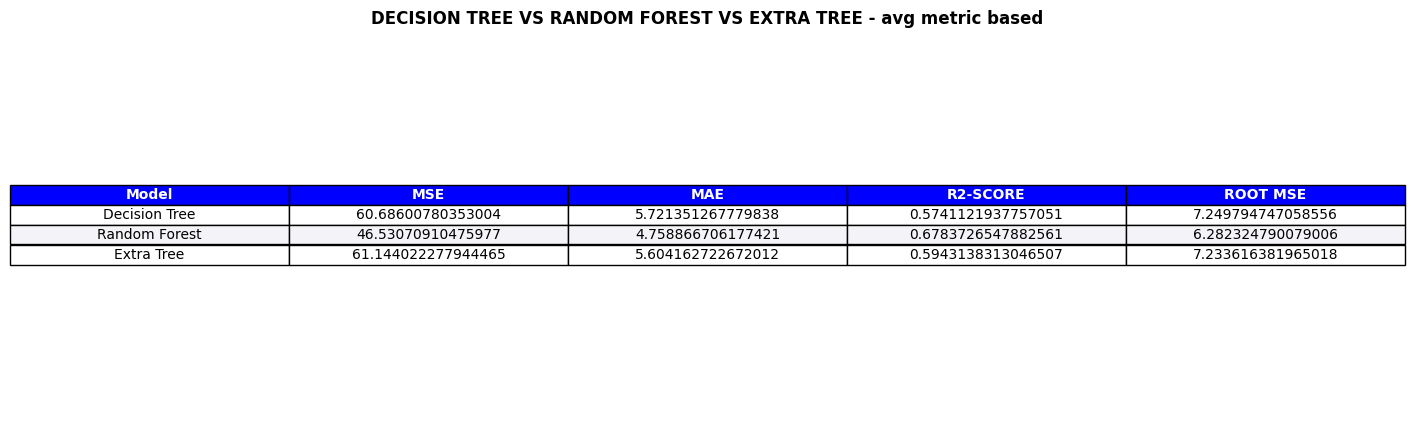

In [31]:
indexes = ['Decision Tree', 'Random Forest', 'Extra Tree']

avg_metrics19 = {
    'MSE': [tree_mse19.mean(), rf_mse19.mean(), extra_mse19.mean()],
    'MAE': [tree_mae19.mean(), rf_mae19.mean(), extra_mae19.mean()],
    'R2-SCORE': [tree_r219.mean(), rf_r219.mean(), extra_r219.mean()],
    'ROOT MSE': [tree_root_mse19.mean(), rf_root_mse19.mean(), extra_root_mse19.mean()]
}

df_avg19 = pd.DataFrame(avg_metrics19)

single_metrics19 = {
    'MSE' : [tree_mse19, rf_mse19, extra_mse19],
    'MAE' : [tree_mae19, rf_mae19, extra_mae19],
    'R2-SCORE' : [tree_r219, rf_r219, extra_r219],
    'ROOT MSE ' : [tree_root_mse19, rf_root_mse19, extra_root_mse19]
}
formatted_single_metrics19 = markdown_table(single_metrics19, y_marathon)
df_single19 = pd.DataFrame(formatted_single_metrics19, index=indexes)

print(tabulate(df_single19, headers='keys', tablefmt='grid', showindex=True))

fig, axes = plt.subplots(figsize=(15,5))  
create_metric_table(df_avg19, 'DECISION TREE VS RANDOM FOREST VS EXTRA TREE - avg metric based', indexes, axes)
plt.show()


## __CALCULATE MEAN+-STD.DEV INTERVAL__

### __INTERVAL FOR TREE__

In [158]:
# NOTE create arrays
weight= np.array([single_metrics17['R2-SCORE'][0][0], single_metrics18['R2-SCORE'][0][0], single_metrics19['R2-SCORE'][0][0]])
weeklyKM= np.array([single_metrics17['R2-SCORE'][0][1], single_metrics18['R2-SCORE'][0][1], single_metrics19['R2-SCORE'][0][1]])
vo2max= np.array([single_metrics17['R2-SCORE'][0][2], single_metrics18['R2-SCORE'][0][2], single_metrics19['R2-SCORE'][0][2]]) 

weight_mean = np.mean(weight)
weeklyKM_mean = np.mean(weeklyKM)
vo2max_mean = np.mean(vo2max)

# NOTE calculate stdev
weight_std = np.std(weight)
weeklyKM_std = np.std(weeklyKM)
vo2max_std = np.std(vo2max)

weight_interval = (weight_mean - weight_std, weight_mean + weight_std)
weeklyKM_interval = (weeklyKM_mean - weeklyKM_std, weeklyKM_mean + weeklyKM_std)
vo2max_interval = (vo2max_mean - vo2max_std, vo2max_mean + vo2max_std)

print(f"Weight interval:   {weight_interval[0]:.2f} to {weight_interval[1]:.2f}")
print(f"WeeklyKM interval: {weeklyKM_interval[0]:.2f} to {weeklyKM_interval[1]:.2f}")
print(f"VO2Max interval:   {vo2max_interval[0]:.2f} to {vo2max_interval[1]:.2f}")

Weight interval:   0.19 to 0.60
WeeklyKM interval: 0.77 to 0.79
VO2Max interval:   0.12 to 0.68


### __INTERVAL FOR RANDOM FOREST__

In [156]:
# NOTE create arrays
weight= np.array([single_metrics17['R2-SCORE'][1][0], single_metrics18['R2-SCORE'][1][0], single_metrics19['R2-SCORE'][1][0]])
weeklyKM= np.array([single_metrics17['R2-SCORE'][1][1], single_metrics18['R2-SCORE'][1][1], single_metrics19['R2-SCORE'][1][1]])
vo2max= np.array([single_metrics17['R2-SCORE'][1][2], single_metrics18['R2-SCORE'][1][2], single_metrics19['R2-SCORE'][1][2]]) 

weight_mean = np.mean(weight)
weeklyKM_mean = np.mean(weeklyKM)
vo2max_mean = np.mean(vo2max)

# NOTE calculate stdev
weight_std = np.std(weight)
weeklyKM_std = np.std(weeklyKM)
vo2max_std = np.std(vo2max)

weight_interval = (weight_mean - weight_std, weight_mean + weight_std)
weeklyKM_interval = (weeklyKM_mean - weeklyKM_std, weeklyKM_mean + weeklyKM_std)
vo2max_interval = (vo2max_mean - vo2max_std, vo2max_mean + vo2max_std)

print(f"Weight interval:   {weight_interval[0]:.2f} to {weight_interval[1]:.2f}")
print(f"WeeklyKM interval: {weeklyKM_interval[0]:.2f} to {weeklyKM_interval[1]:.2f}")
print(f"VO2Max interval:   {vo2max_interval[0]:.2f} to {vo2max_interval[1]:.2f}")

Weight interval:   0.33 to 0.71
WeeklyKM interval: 0.76 to 0.86
VO2Max interval:   0.35 to 0.76


### __INTERVAL FOR EXTRA TREES__

In [157]:
# NOTE create arrays
weight= np.array([single_metrics17['R2-SCORE'][2][0], single_metrics18['R2-SCORE'][2][0], single_metrics19['R2-SCORE'][2][0]])
weeklyKM= np.array([single_metrics17['R2-SCORE'][2][1], single_metrics18['R2-SCORE'][2][1], single_metrics19['R2-SCORE'][2][1]])
vo2max= np.array([single_metrics17['R2-SCORE'][2][2], single_metrics18['R2-SCORE'][2][2], single_metrics19['R2-SCORE'][2][2]]) 

weight_mean = np.mean(weight)
weeklyKM_mean = np.mean(weeklyKM)
vo2max_mean = np.mean(vo2max)

# NOTE calculate stdev
weight_std = np.std(weight)
weeklyKM_std = np.std(weeklyKM)
vo2max_std = np.std(vo2max)

weight_interval = (weight_mean - weight_std, weight_mean + weight_std)
weeklyKM_interval = (weeklyKM_mean - weeklyKM_std, weeklyKM_mean + weeklyKM_std)
vo2max_interval = (vo2max_mean - vo2max_std, vo2max_mean + vo2max_std)

print(f"Weight interval:   {weight_interval[0]:.2f} to {weight_interval[1]:.2f}")
print(f"WeeklyKM interval: {weeklyKM_interval[0]:.2f} to {weeklyKM_interval[1]:.2f}")
print(f"VO2Max interval:   {vo2max_interval[0]:.2f} to {vo2max_interval[1]:.2f}")

Weight interval:   0.24 to 0.83
WeeklyKM interval: 0.73 to 0.90
VO2Max interval:   0.54 to 0.85


## __K-FOLD FOR ALL MULTIOUTPUT TREE__

In [51]:
# X_tmp, X_test, y_tmp, y_test = train_test_split(X_marathon,y_marathon, test_size=0.2, random_state=42)
r2_scores_ten,rmses_ten = compute_K_fold(ExtraTreesRegressor,X_marathon,y_marathon,10)
r2_scores_five,rmses_five = compute_K_fold(ExtraTreesRegressor,X_marathon,y_marathon,5)


print(f"R2 Squared Mean -> 10 folds: {np.mean(r2_scores_ten)} vs 5 folds: {np.mean(r2_scores_five)} ")
print(f"RMSE -> 10 folds: {np.mean(rmses_ten)} vs 5 folds: {np.mean(rmses_five)} ")

R2 Squared Mean -> 10 folds: 0.39799832740015495 vs 5 folds: 0.4377735866403591 
RMSE -> 10 folds: 8.852086537562174 vs 5 folds: 9.141003014371808 


In [52]:
# X_tmp, X_test, y_tmp, y_test = train_test_split(X_marathon,y_marathon, test_size=0.2, random_state=42)
r2_scores_ten,rmses_ten = compute_K_fold(RandomForestRegressor,X_marathon,y_marathon,10)
r2_scores_five,rmses_five = compute_K_fold(RandomForestRegressor,X_marathon,y_marathon,5)

print(f"R2 Squared Mean -> 10 folds: {np.mean(r2_scores_ten)} vs 5 folds: {np.mean(r2_scores_five)} ")
print(f"RMSE -> 10 folds: {np.mean(rmses_ten)} vs 5 folds: {np.mean(rmses_five)} ")

R2 Squared Mean -> 10 folds: 0.3431109432167248 vs 5 folds: 0.4031149925743896 
RMSE -> 10 folds: 9.098726869382332 vs 5 folds: 9.409285381139517 


In [53]:
# X_tmp, X_test, y_tmp, y_test = train_test_split(X_marathon,y_marathon, test_size=0.2, random_state=42)
r2_scores_ten,rmses_ten = compute_K_fold(DecisionTreeRegressor,X_marathon,y_marathon,10)
r2_scores_five,rmses_five = compute_K_fold(DecisionTreeRegressor,X_marathon,y_marathon,5)

print(f"R2 Squared Mean -> 10 folds: {np.mean(r2_scores_ten)} vs 5 folds: {np.mean(r2_scores_five)} ")
print(f"RMSE -> 10 folds: {np.mean(rmses_ten)} vs 5 folds: {np.mean(rmses_five)} ")

R2 Squared Mean -> 10 folds: -0.35533652599713156 vs 5 folds: -0.14215987887421294 
RMSE -> 10 folds: 12.409448169298361 vs 5 folds: 12.555784889364844 


## __*PREDICTION INTERVALS*__

In [165]:

# Remake the split, random_state gives the possibility of recreating the same split with which the models were trained
X_tmp, X_test, y_tmp, y_test = train_test_split(X_marathon,y_marathon, test_size=0.2, random_state=20) 
X_train, X_validation, y_train, y_validation = train_test_split(X_tmp,y_tmp, test_size=0.125, random_state=20) 

# Create array of predictions for both estimators
rf_preds = np.array([tree.predict(X_validation) for tree in rf19.estimators_])
et_preds = np.array([tree.predict(X_validation) for tree in extra19.estimators_])

# USING 95% !!!!! It is very important to have somewhat a range of confidence for which advising the thlete is not a direct number but a value in between a range 
# NOTE : ML models are not always perfect, especilly with the small dataset that I have, it is fully advise to have a good confidence interval!
rf_lower = np.percentile(rf_preds, 5, axis=0)
rf_upper = np.percentile(rf_preds, 95, axis=0)

et_lower = np.percentile(et_preds, 5, axis=0)
et_upper = np.percentile(et_preds, 95, axis=0)

results = pd.DataFrame(X_validation, columns=[f"{y_validation.columns[i]}" for i in range(y_validation.shape[1])])
rf_pred = rf19.predict(X_validation)
et_pred = extra19.predict(X_validation)

for i in range(rf_pred.shape[1]): 

    # store BOTH PERCENTILES and ACTUAL PREDICTIONS. 
    # This gives a way of effectively retrieving a lower and upper bound continous range for the continuous prediction
    results[f"rf_pred_{y_validation.columns[i]}"] = rf_pred[:, i]
    results[f"rf_lower_{y_validation.columns[i]}"] = rf_lower[:, i]
    results[f"rf_upper_{y_validation.columns[i]}"] = rf_upper[:, i]

    results[f"et_pred_{y_validation.columns[i]}"] = et_pred[:, i]
    results[f"et_lower_{y_validation.columns[i]}"] = et_lower[:, i]
    results[f"et_upper_{y_validation.columns[i]}"] = et_upper[:, i]

/home/lamberto/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/home/lamberto/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/home/lamberto/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/home/lamberto/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/home/lamberto/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/home/lamberto/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has

In [166]:
for col in y_marathon.columns:
    print('*' * 100)
    print(f'Prediction interval for the feature -> {col} \n')
    print_intervals(col,results)
    print('*' * 100)

****************************************************************************************************
Prediction interval for the feature -> vo2max 

RF Predictions & Intervals:
      rf_lower_vo2max  rf_pred_vo2max  rf_upper_vo2max
63         34.233333       40.088498        48.892500
131        31.300000       40.432176        47.719583
52         34.374333       41.500005        51.505000
67         46.700000       53.170840        59.850556
113        47.988333       51.567909        56.387361
34         47.665833       51.944616        57.588727
28         41.297321       48.235510        54.406667
73         49.218214       55.063286        59.936731
26         42.800000       51.373400        59.483523
40         39.893571       44.689699        49.013889
4          36.083333       48.624041        57.583250
17         48.715000       53.146056        57.741889
6          47.164583       53.614880        62.100000
23         44.997386       53.125557        58.608167 

ET Predict

## __*USER TRIALS WITH HISTOGRAMS*__

### __*LOGIC TO PLOT HISTOGRAM*__

In [35]:
# converts marathon times from minutes to hr.mm
def convert_marathon_time(time):
    rest = 0
    while(time % 60 != 0):
        rest += 1
        time -= 1
    return str(time//60) + str(rest)

# performs actual prediction and returns an object with the realizations values
def run_trial(user_input,regressor,y):
    user_input_df = pd.DataFrame([user_input])
    predictions = regressor.predict(user_input_df)

    realizations_obj = {
        'time': convert_marathon_time(user_input["marathon_time_in_minutes"]),
    }
    for i,col in enumerate(y.columns):
        realizations_obj[col] = predictions[0][i] 
    
    return realizations_obj


def construct_user (time,height,age,HRmax,days,FFM) :
    user = {
        'marathon_time_in_minutes': time,
        'height' : height,
        'age' : age,
        'HRmax' : HRmax,
        'days' : days,
        'FFM' : FFM,
        # 'bmi' : bmi
    }
    return user

# NOTE: users is a list of prdiction objects
def construct_single_feature_user(pred):
    weight = {}
    weeklyKM = {}
    vo2Max = {} 
    times = ['five', 'four_t', 'four', 'three_t', 'three', 'two_f']
    
    # NOTE: a prediction user is an object with weight,days,weeklyKM,vo2max
    for i,p in enumerate(pred):
        print(p['weight'],p['weeklyKM'],p['vo2max'])
        vo2Max[times[i]]=p['vo2max']
        weight[times[i]]=p['weight']
        weeklyKM[times[i]]=p['weeklyKM']

    # NOTE: removed bmi
    return vo2Max,weight,weeklyKM

# NOTE: returns a list of prediction objects
def make_trials(regressor,times, unchanged):
    trials = []
    for i,time in enumerate(times):
        # NOTE: CALLING run_trial, hence returning prediction objects
        res = run_trial(construct_user(time, **unchanged), regressor, y_marathon)
        trials.append(res)
    return trials

### __*EXTRA TREE HISTOGRAM*__

78.81106865079364 62.18505753968252 46.79926031746033
78.410014484127 63.92330753968252 48.033910317460325
77.96348115079365 67.6941339285714 49.88835476190476
77.4074402777778 70.3961690323565 51.30748147130647
74.59229166666671 73.69495535714283 56.530524206349185
73.8538630952381 79.76551587301584 55.986429761904716


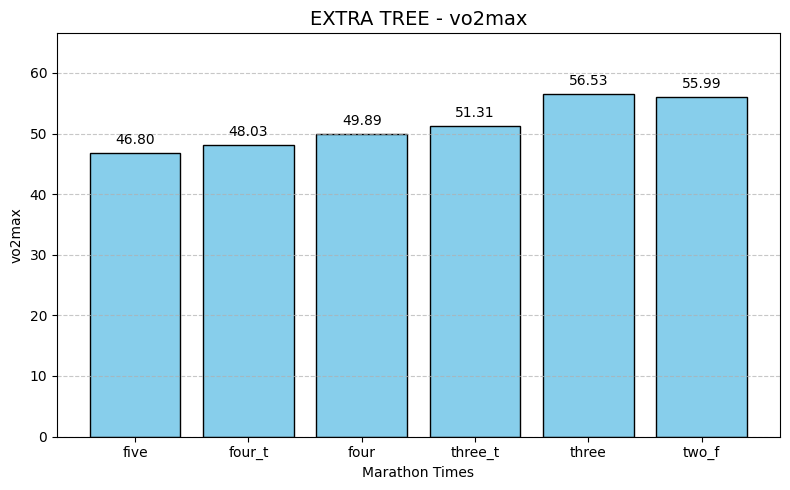

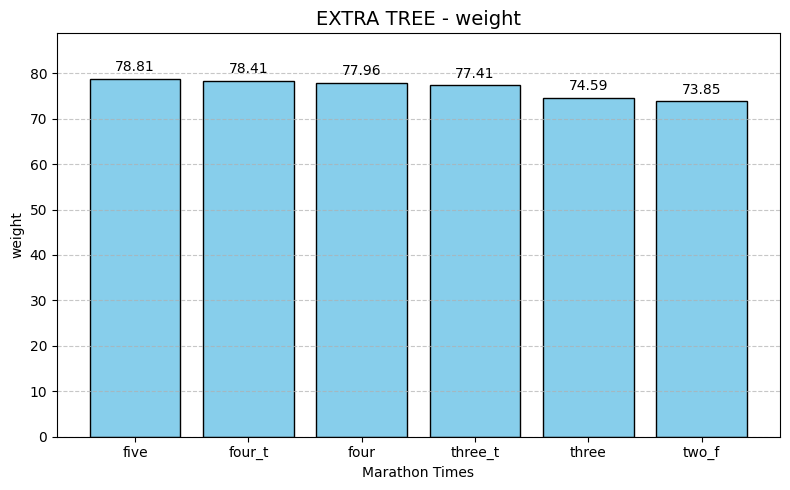

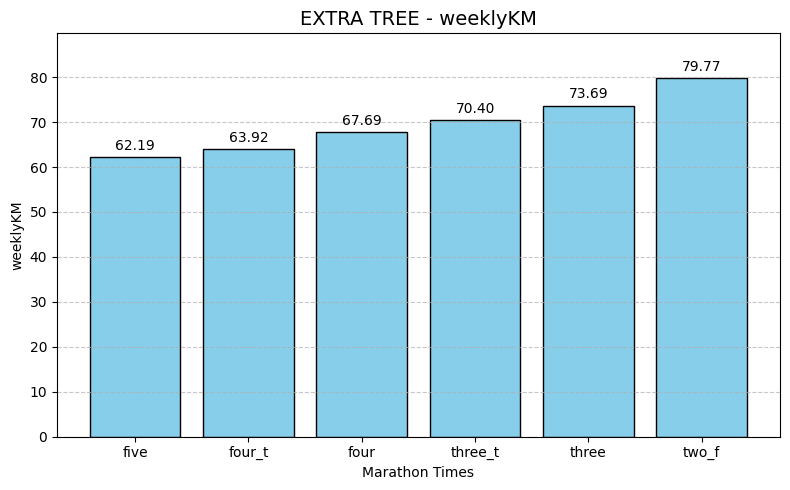

In [128]:
# NOTE!! this are unchanged because we need to test results for different times but same metrics to see if actually methods performs
# NOTE: Partecipant ID - 138 
unchanged = {
    'height' : 178,
    'age' : 30,
    'HRmax' : 186,
    'days' : 6,
    'FFM' : 64.53
}

prediction_arr = list(construct_single_feature_user(make_trials(extra18,[300,270,240,210,180,160],unchanged)))

for i,pred_elem in enumerate(prediction_arr):
    title = ['vo2max', 'weight', 'weeklyKM']
    plot_histogram_single_features(pred_elem, f'EXTRA TREE - {title[i]}', title[i],'Marathon Times')

### __*RANDOM FOREST HISTOGRAMS*__

77.01134918647526 44.62027901406871 46.82380822854976
76.31274175224286 46.563173174075374 48.358696566600585
75.30757370639981 46.13703055558276 50.13803324242478
74.6899794859552 45.56273262480981 52.04143660857116
73.97040601914426 47.903235871563076 52.85762790546872
73.82467631135205 50.17280161831633 52.832002292193096


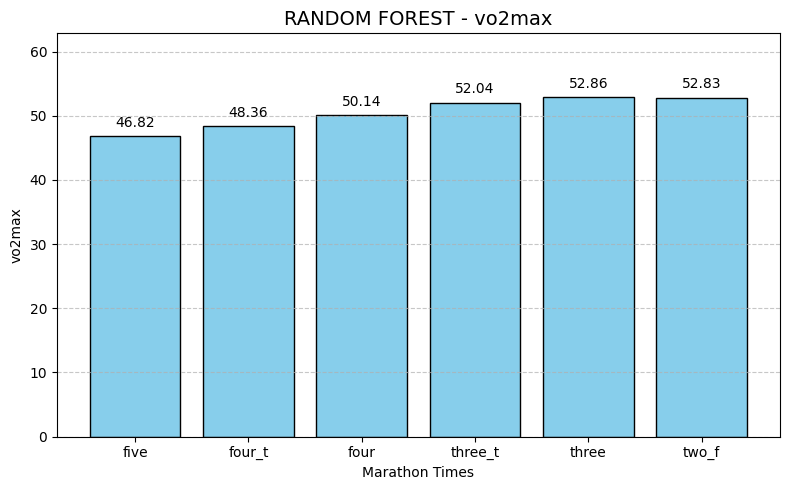

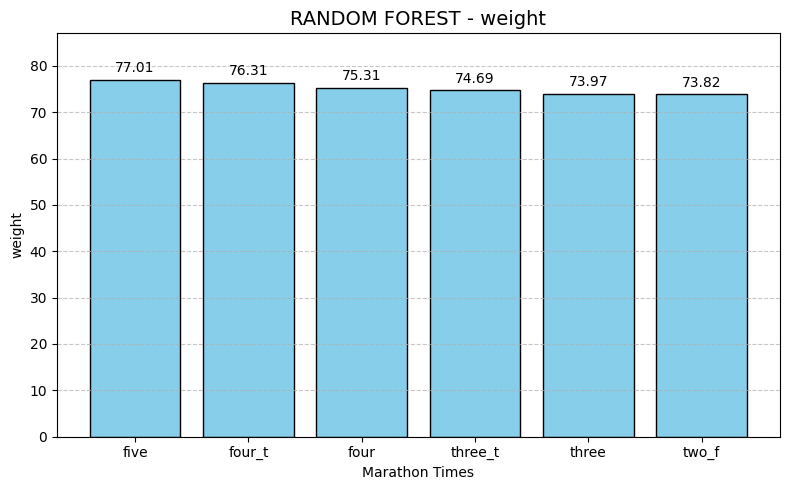

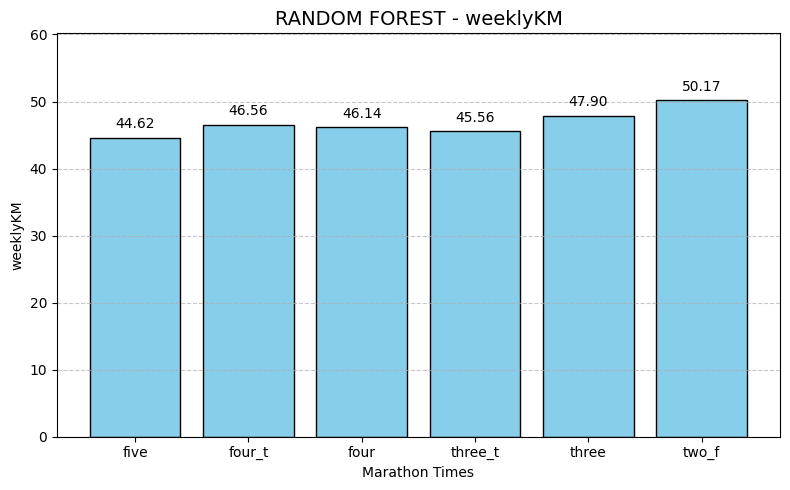

In [41]:
# NOTE!! this are unchanged because we need to test results for different times but same metrics to see if actually methods performs
# NOTE: Partecipant ID - 138
unchanged = {
    'height' : 175,
    'age' : 31,
    'HRmax' : 196,
    'days' : 4,
    'FFM' : 62.96
}
prediction_arr = list(construct_single_feature_user(make_trials(rf18,[300,270,240,210,180,160],unchanged)))

for i,pred_elem in enumerate(prediction_arr):
    title = ['vo2max', 'weight', 'weeklyKM']
    plot_histogram_single_features(pred_elem, f'RANDOM FOREST - {title[i]}', title[i], 'Marathon Times')

### __*DECISION TREE HISTOGRMS*__

74.19090909090909 39.77272727272727 43.03636363636363
74.19090909090909 39.77272727272727 43.03636363636363
71.31818181818181 48.18181818181818 48.26363636363636
70.35 37.1875 56.862500000000004
70.35 37.1875 56.862500000000004
70.35 37.1875 56.862500000000004


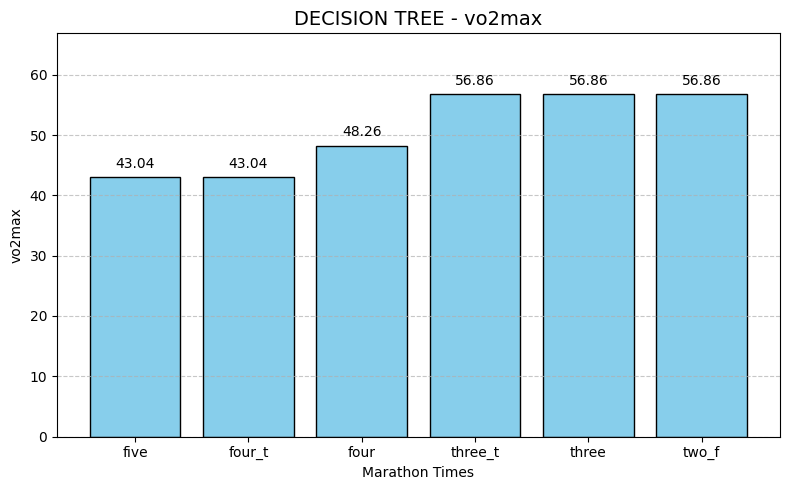

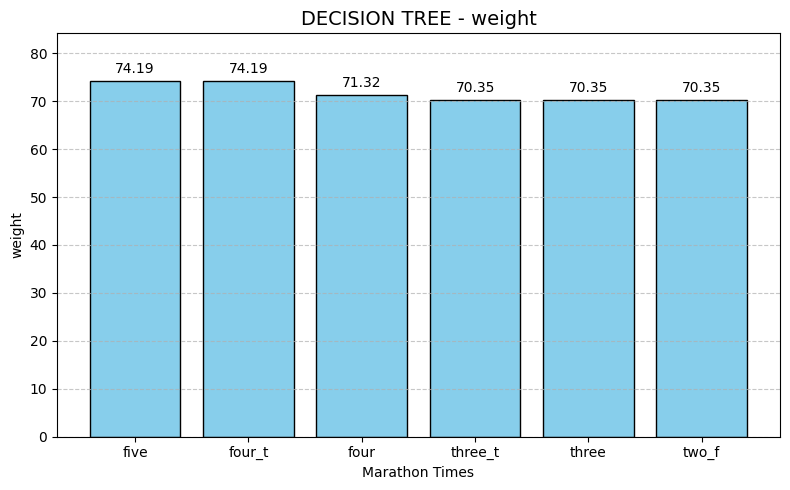

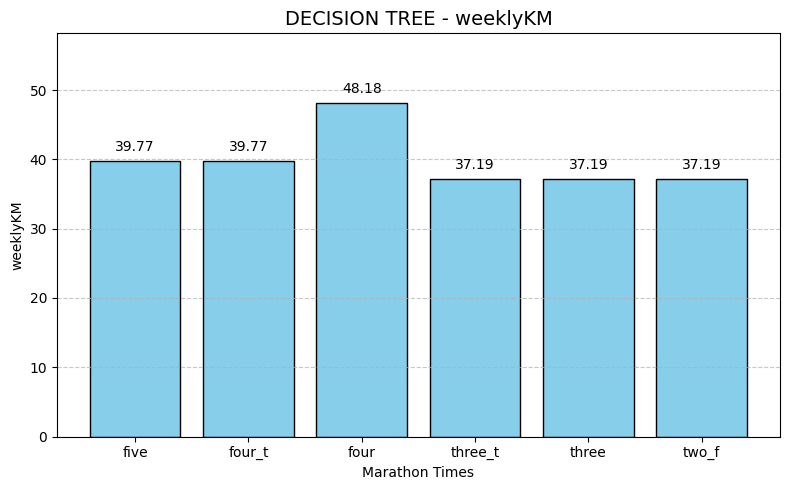

In [39]:
# NOTE!! this are unchanged because we need to test results for different times but same metrics to see if actually methods performs
# NOTE: Partecipant ID - 138
unchanged = {
    'height' : 175,
    'age' : 31,
    'HRmax' : 196,
    'days' : 4,
    'FFM' : 62.96
}
prediction_arr = list(construct_single_feature_user(make_trials(tree18,[300,270,240,210,180,160],unchanged)))

for i,pred_elem in enumerate(prediction_arr):
    title = ['vo2max', 'weight', 'weeklyKM']
    plot_histogram_single_features(pred_elem, f'DECISION TREE - {title[i]}', title[i], 'Marathon Times')

## __TEST MODEL ON UNSEEN TEST DATA__

In [125]:
X_tmp, X_test, y_tmp, y_test = train_test_split(X_marathon,y_marathon,test_size=0.2, random_state=20) 
for i in range(len(y_test)):
    print(y_test.iloc[i])
    print(X_test.iloc[i])


vo2max      63.1
weight      70.7
weeklyKM    60.0
Name: 83, dtype: float64
marathon_time_in_minutes    207.00
height                      179.20
age                          38.00
HRmax                       195.00
days                          5.00
FFM                          59.11
Name: 83, dtype: float64
vo2max      54.3
weight      80.6
weeklyKM    50.0
Name: 108, dtype: float64
marathon_time_in_minutes    253.00
height                      179.60
age                          41.00
HRmax                       189.00
days                          4.00
FFM                          68.59
Name: 108, dtype: float64
vo2max       48.0
weight       61.1
weeklyKM    110.0
Name: 68, dtype: float64
marathon_time_in_minutes    179.0
height                      169.5
age                          52.0
HRmax                       161.0
days                          7.0
FFM                          52.0
Name: 68, dtype: float64
vo2max      50.3
weight      68.5
weeklyKM    50.0
Name: 80, dtype: 

In [142]:

def compute_metrics_on_unseen_data(model,X,y, seed):
    X_tmp, X_test, y_tmp, y_test = train_test_split(X,y,test_size=0.2, random_state=seed) 
    prediction = model.predict(X_test)
    r2 = r2_score(y_test,prediction)
    r2_raw = r2_score(y_test, prediction, multioutput='raw_values')
    mse = mean_squared_error(y_test,prediction)
    rmse = root_mean_squared_error(y_test,prediction)

    return r2,mse,rmse,r2_raw,prediction,y_test

### __EXTRA TREE 18 AND 19__

In [143]:
unseen_r2_extra,unseen_mse_extra,unseen_rmse_extra,r2_raw_extra,prediction_extra,test_set_extra = compute_metrics_on_unseen_data(extra18, X_marathon,y_marathon,20)
print(f'the R2 for unseen data for Decision tree is : {unseen_r2_extra}')
print(f'the MSE for unseen data for Decision tree is : {unseen_mse_extra} ')
print(f'the RMSE for unseen data for Decision tree is : {unseen_rmse_extra} ')
print(f'the Single realizations R2: weight,days,weeklyKM,vo2max : {r2_raw_extra}')
for i,pred in enumerate(prediction_extra):
    print('*'*100)
    print(f'vo2max : real -> {test_set_extra.iloc[i]["vo2max"]}, predicted -> {pred[0]}')
    print(f'weight : real -> {test_set_extra.iloc[i]["weight"]}, predicted -> {pred[1]}')
    print(f'weeklyKM : real -> {test_set_extra.iloc[i]["weeklyKM"]}, predicted -> {pred[2]}')

the R2 for unseen data for Decision tree is : 0.6123039797634582
the MSE for unseen data for Decision tree is : 88.10710382796361 
the RMSE for unseen data for Decision tree is : 8.106972326435894 
the Single realizations R2: weight,days,weeklyKM,vo2max : [0.37035391 0.83275308 0.63380495]
****************************************************************************************************
vo2max : real -> 63.1, predicted -> 54.41148581298154
weight : real -> 70.7, predicted -> 72.35746256057877
weeklyKM : real -> 60.0, predicted -> 59.62201632055053
****************************************************************************************************
vo2max : real -> 54.3, predicted -> 47.64104401025815
weight : real -> 80.6, predicted -> 81.33845668083768
weeklyKM : real -> 50.0, predicted -> 47.43874473510982
****************************************************************************************************
vo2max : real -> 48.0, predicted -> 50.79914285714283
weight : real -> 61.1, p

In [144]:
unseen_r2_extra,unseen_mse_extra,unseen_rmse_extra,r2_raw_extra,prediction_extra,test_set_extra = compute_metrics_on_unseen_data(extra19, X_marathon,y_marathon,35)
print(f'the R2 for unseen data for Decision tree is : {unseen_r2_extra}')
print(f'the MSE for unseen data for Decision tree is : {unseen_mse_extra} ')
print(f'the RMSE for unseen data for Decision tree is : {unseen_rmse_extra} ')
print(f'the Single realizations R2: weight,days,weeklyKM,vo2max : {r2_raw_extra}')
for i,pred in enumerate(prediction_extra):
    print('*'*100)
    print(f'vo2max : real -> {test_set_extra.iloc[i]["vo2max"]}, predicted -> {pred[0]}')
    print(f'weight : real -> {test_set_extra.iloc[i]["weight"]}, predicted -> {pred[1]}')
    print(f'weeklyKM : real -> {test_set_extra.iloc[i]["weeklyKM"]}, predicted -> {pred[2]}')

the R2 for unseen data for Decision tree is : 0.5147128841484626
the MSE for unseen data for Decision tree is : 114.14169503279413 
the RMSE for unseen data for Decision tree is : 9.643462959640688 
the Single realizations R2: weight,days,weeklyKM,vo2max : [0.44749444 0.64225817 0.45438604]
****************************************************************************************************
vo2max : real -> 51.3, predicted -> 52.12433716931228
weight : real -> 78.2, predicted -> 73.33995939153452
weeklyKM : real -> 95.0, predicted -> 82.08696097883599
****************************************************************************************************
vo2max : real -> 50.9, predicted -> 48.885463185684856
weight : real -> 81.4, predicted -> 80.19669229677693
weeklyKM : real -> 45.0, predicted -> 66.31604033737875
****************************************************************************************************
vo2max : real -> 61.8, predicted -> 52.97360654120214
weight : real -> 61.9,

### __RANDOM FOREST 18 AND 19__

In [145]:
unseen_r2_rf,unseen_mse_rf,unseen_rmse_rf,r2_raw_rf,prediction_rf,test_set_rf = compute_metrics_on_unseen_data(rf18, X_marathon,y_marathon,20)
print(f'the R2 for unseen data for Random Forest is : {unseen_r2_rf}')
print(f'the MSE for unseen data for Random Forest is : {unseen_mse_rf} ')
print(f'the RMSE for unseen data for Random Forest is : {unseen_rmse_rf} ')
print(f'the Single realizations R2: weight,days,weeklyKM,vo2max : {r2_raw_rf}')
for i,pred in enumerate(prediction_rf):
    print('*'*100)
    print(f'vo2max : real -> {test_set_rf.iloc[i]["vo2max"]}, predicted -> {pred[0]}')
    print(f'weight : real -> {test_set_rf.iloc[i]["weight"]}, predicted -> {pred[1]}')
    print(f'weeklyKM : real -> {test_set_rf.iloc[i]["weeklyKM"]}, predicted -> {pred[2]}')

the R2 for unseen data for Random Forest is : 0.5900934793877047
the MSE for unseen data for Random Forest is : 88.93790413192364 
the RMSE for unseen data for Random Forest is : 8.206372235818126 
the Single realizations R2: weight,days,weeklyKM,vo2max : [0.3033315  0.82864729 0.63830166]
****************************************************************************************************
vo2max : real -> 63.1, predicted -> 53.67726012896423
weight : real -> 70.7, predicted -> 70.5060759055895
weeklyKM : real -> 60.0, predicted -> 64.69473212530933
****************************************************************************************************
vo2max : real -> 54.3, predicted -> 46.79038916292041
weight : real -> 80.6, predicted -> 81.7859739545177
weeklyKM : real -> 50.0, predicted -> 45.97731787032413
****************************************************************************************************
vo2max : real -> 48.0, predicted -> 52.83739021187147
weight : real -> 61.1, pre

In [146]:
unseen_r2_rf,unseen_mse_rf,unseen_rmse_rf,r2_raw_rf,prediction_rf,test_set_rf = compute_metrics_on_unseen_data(rf19, X_marathon,y_marathon,35)
print(f'the R2 for unseen data for Decision tree is : {unseen_r2_rf}')
print(f'the MSE for unseen data for Decision tree is : {unseen_mse_rf} ')
print(f'the RMSE for unseen data for Decision tree is : {unseen_rmse_rf} ')
print(f'the Single realizations R2: weight,days,weeklyKM,vo2max : {r2_raw_rf}')
for i,pred in enumerate(prediction_rf):
    print('*'*100)
    print(f'vo2max : real -> {test_set_rf.iloc[i]["vo2max"]}, predicted -> {pred[0]}')
    print(f'weight : real -> {test_set_rf.iloc[i]["weight"]}, predicted -> {pred[1]}')
    print(f'weeklyKM : real -> {test_set_rf.iloc[i]["weeklyKM"]}, predicted -> {pred[2]}')

the R2 for unseen data for Decision tree is : 0.4960456797482471
the MSE for unseen data for Decision tree is : 126.84920579502405 
the RMSE for unseen data for Decision tree is : 9.961220661458205 
the Single realizations R2: weight,days,weeklyKM,vo2max : [0.45072565 0.67174701 0.36566438]
****************************************************************************************************
vo2max : real -> 51.3, predicted -> 52.47043207070708
weight : real -> 78.2, predicted -> 77.52821796536794
weeklyKM : real -> 95.0, predicted -> 76.47364069264071
****************************************************************************************************
vo2max : real -> 50.9, predicted -> 49.10184678932177
weight : real -> 81.4, predicted -> 81.01465422077924
weeklyKM : real -> 45.0, predicted -> 68.46063816738818
****************************************************************************************************
vo2max : real -> 61.8, predicted -> 55.06328609446107
weight : real -> 61.9, 

### __TREE 18 AND 19__

In [147]:
unseen_r2_tree,unseen_mse_tree,unseen_rmse_tree,r2_raw_tree,prediction_tree,test_set_tree = compute_metrics_on_unseen_data(tree18, X_marathon,y_marathon,20)
print(f'the R2 for unseen data for Extra tree is : {unseen_r2_tree}')
print(f'the MSE for unseen data for Extra tree is : {unseen_mse_tree} ')
print(f'the RMSE for unseen data for Extra tree is : {unseen_rmse_tree} ')
print(f'the Single realizations R2: weight,days,weeklyKM,vo2max : {r2_raw_tree}')

for i,pred in enumerate(prediction_tree):
    print('*'*100)
    print(f'vo2max : real -> {test_set_tree.iloc[i]["vo2max"]}, predicted -> {pred[0]}')
    print(f'weight : real -> {test_set_tree.iloc[i]["weight"]}, predicted -> {pred[1]}')
    print(f'weeklyKM : real -> {test_set_tree.iloc[i]["weeklyKM"]}, predicted -> {pred[2]}')


the R2 for unseen data for Extra tree is : 0.4368752368514697
the MSE for unseen data for Extra tree is : 118.334898163744 
the RMSE for unseen data for Extra tree is : 9.684117411953952 
the Single realizations R2: weight,days,weeklyKM,vo2max : [0.22261639 0.56716839 0.52084093]
****************************************************************************************************
vo2max : real -> 63.1, predicted -> 57.4875
weight : real -> 70.7, predicted -> 66.05
weeklyKM : real -> 60.0, predicted -> 78.75
****************************************************************************************************
vo2max : real -> 54.3, predicted -> 47.720000000000006
weight : real -> 80.6, predicted -> 81.20666666666668
weeklyKM : real -> 50.0, predicted -> 48.67333333333333
****************************************************************************************************
vo2max : real -> 48.0, predicted -> 47.145454545454534
weight : real -> 61.1, predicted -> 75.74545454545454
weeklyKM : r

In [148]:
unseen_r2_tree,unseen_mse_tree,unseen_rmse_tree,r2_raw_tree,prediction_tree,test_set_tree = compute_metrics_on_unseen_data(tree19, X_marathon,y_marathon,35)
print(f'the R2 for unseen data for Decision tree is : {unseen_r2_tree}')
print(f'the MSE for unseen data for Decision tree is : {unseen_mse_tree} ')
print(f'the RMSE for unseen data for Decision tree is : {unseen_rmse_tree} ')
print(f'the Single realizations R2: weight,days,weeklyKM,vo2max : {r2_raw_tree}')
for i,pred in enumerate(prediction_tree):
    print('*'*100)
    print(f'vo2max : real -> {test_set_tree.iloc[i]["vo2max"]}, predicted -> {pred[0]}')
    print(f'weight : real -> {test_set_tree.iloc[i]["weight"]}, predicted -> {pred[1]}')
    print(f'weeklyKM : real -> {test_set_tree.iloc[i]["weeklyKM"]}, predicted -> {pred[2]}')

the R2 for unseen data for Decision tree is : 0.35360230749362476
the MSE for unseen data for Decision tree is : 174.74872667514308 
the RMSE for unseen data for Decision tree is : 11.46303809189356 
the Single realizations R2: weight,days,weeklyKM,vo2max : [0.36599572 0.59935768 0.09545352]
****************************************************************************************************
vo2max : real -> 51.3, predicted -> 51.53636363636363
weight : real -> 78.2, predicted -> 75.51818181818182
weeklyKM : real -> 95.0, predicted -> 76.4090909090909
****************************************************************************************************
vo2max : real -> 50.9, predicted -> 47.86
weight : real -> 81.4, predicted -> 82.94
weeklyKM : real -> 45.0, predicted -> 69.25
****************************************************************************************************
vo2max : real -> 61.8, predicted -> 53.100000000000016
weight : real -> 61.9, predicted -> 68.66666666666667
week

It looks like the models are actually able to perform well on unseen data. 

__KEEP IN MIND THAT "WELL" IS ALWAYS IN RELATION TO THE FACT THAT WE DON'T HAVE MUCH DATA!__

## __*CALORIES DATASET*__

In [8]:
calories = pd.read_csv('cardioActivities.csv')
calories.isnull().sum()

Date                          0
Activity Id                   0
Type                          0
Route Name                  507
Distance (km)                 0
Duration                      0
Average Pace                  0
Average Speed (km/h)          0
Calories Burned               0
Climb (m)                     0
Average Heart Rate (bpm)    214
Friend's Tagged             508
Notes                       277
GPX File                      4
dtype: int64

In [9]:
calories.head()

,Date,Activity Id,Type,Route Name,Distance (km),Duration,Average Pace,Average Speed (km/h),Calories Burned,Climb (m),Average Heart Rate (bpm),Friend's Tagged,Notes,GPX File
0,2018-11-11 14:05:12,c9627fed-14ac-47a2-bed3-2a2630c63c15,Running,NaN,10.44,58:40,5:37,10.68,774.0,130,159.0,NaN,NaN,2018-11-11-140512.gpx
1,2018-11-09 15:02:35,be65818d-a801-4847-a43b-2acdf4dc70e7,Running,NaN,12.84,1:14:12,5:47,10.39,954.0,168,159.0,NaN,NaN,2018-11-09-150235.gpx
2,2018-11-04 16:05:00,c09b2f92-f855-497c-b624-c196b3ef036c,Running,NaN,13.01,1:15:16,5:47,10.37,967.0,171,155.0,NaN,NaN,2018-11-04-160500.gpx
3,2018-11-01 14:03:58,bc9b612d-3499-43ff-b82a-9b17b71b8a36,Running,NaN,12.98,1:14:25,5:44,10.47,960.0,169,158.0,NaN,NaN,2018-11-01-140358.gpx
4,2018-10-27 17:01:36,972567b2-1b0e-437c-9e82-fef8078d6438,Running,NaN,13.02,1:12:50,5:36,10.73,967.0,170,154.0,NaN,NaN,2018-10-27-170136.gpx


In [10]:
print(calories['Type'].unique())

['Running' 'Cycling' 'Other' 'Walking']


### __FILTER ONLY THE RUNNING ACTIVITIES__

In [11]:
calories = calories[calories['Type'] == 'Running']

In [12]:
print(calories['Type'].unique())

['Running']


In [13]:
calories = calories.drop(columns=['Route Name', "Friend's Tagged", 'Date', 'Activity Id', 'Notes', 'GPX File'])
calories = calories.dropna(subset=['Average Heart Rate (bpm)',])
calories.isnull().sum()

Type                        0
Distance (km)               0
Duration                    0
Average Pace                0
Average Speed (km/h)        0
Calories Burned             0
Climb (m)                   0
Average Heart Rate (bpm)    0
dtype: int64

In [14]:
def time_to_minutes(time_str):
    if pd.isna(time_str):
        return pd.NA 
    t = time_str.split(':')
    return int(t[0]) * 60 + int(t[1])

# NOTE: kept in minutes, trimmed seconds
calories['Duration'] = calories['Duration'].apply(time_to_minutes)
calories['Average Pace'] = calories['Average Pace'].str.replace(':', '.').astype(float, errors='ignore')
calories.head()

,Type,Distance (km),Duration,Average Pace,Average Speed (km/h),Calories Burned,Climb (m),Average Heart Rate (bpm)
0,Running,10.44,3520,5.37,10.68,774.0,130,159.0
1,Running,12.84,74,5.47,10.39,954.0,168,159.0
2,Running,13.01,75,5.47,10.37,967.0,171,155.0
3,Running,12.98,74,5.44,10.47,960.0,169,158.0
4,Running,13.02,72,5.36,10.73,967.0,170,154.0


In [15]:
print(calories.dtypes)

Type                         object
Distance (km)               float64
Duration                      int64
Average Pace                float64
Average Speed (km/h)        float64
Calories Burned             float64
Climb (m)                     int64
Average Heart Rate (bpm)    float64
dtype: object


In [16]:
X_calories = calories[['Distance (km)', 'Duration', 'Average Heart Rate (bpm)',  'Average Pace']]
Y_calories = calories[['Calories Burned', 'Average Speed (km/h)']]
X_calories.count()

Distance (km)               277
Duration                    277
Average Heart Rate (bpm)    277
Average Pace                277
dtype: int64

In [55]:
tree, tree_train, tree_mse, tree_mae, tree_r2, tree_mape, tree_mape_single, tree_root_mse = perform_tree_regression(DecisionTreeRegressor,X_calories,Y_calories,False)
rf, rf_train, rf_mse, rf_mae, rf_r2, rf_mape, rf_mape_single, rf_root_mse = perform_tree_regression(RandomForestRegressor,X_calories,Y_calories,True)
extra, extra_train, extra_mse, extra_mae, extra_r2, extra_mape, extra_mape_single, extra_root_mse = perform_tree_regression(ExtraTreesRegressor,X_calories,Y_calories,True)

+---------------+-------------------------------------------+--------------------------------------------+----------------------------------------------+--------------------------------------------+-------------------------------------------+
|               | MSE                                       | MAE                                        | R2-SCORE                                     | MAPE                                       | ROOT MSE                                  |
+===============+===========================================+============================================+==============================================+============================================+===========================================+
| Decision Tree | Calories Burned : 3878.7790121605312      | Calories Burned : 34.56559706400912        | Calories Burned : 0.9632113946442562         | Calories Burned : 0.15442595462996542      | Calories Burned : 62.279844349199614      |
|               | Average Sp

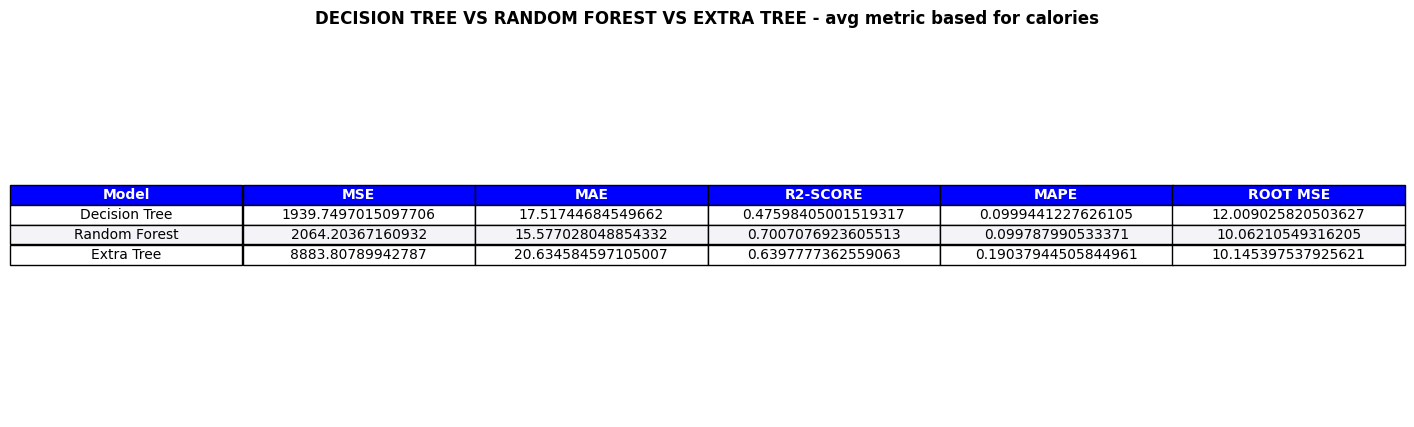

In [56]:
indexes = ['Decision Tree', 'Random Forest', 'Extra Tree']

avg_metrics = {
    'MSE': [tree_mse.mean(), rf_mse.mean(), extra_mse.mean()],
    'MAE': [tree_mae.mean(), rf_mae.mean(), extra_mae.mean()],
    'R2-SCORE': [tree_r2.mean(), rf_r2.mean(), extra_r2.mean()],
    'MAPE': [tree_mape, rf_mape, extra_mape],
    'ROOT MSE': [tree_root_mse5.mean(), rf_root_mse5.mean(), extra_root_mse5.mean()]
}
df_avg1 = pd.DataFrame(avg_metrics)

single_metrics = {
    'MSE' : [tree_mse, rf_mse, extra_mse],
    'MAE' :[tree_mae, rf_mae, extra_mae],
    'R2-SCORE' :[tree_r2, rf_r2, extra_r2],
    'MAPE' :[tree_mape_single, rf_mape_single, extra_mape_single],
    'ROOT MSE ' :[tree_root_mse, rf_root_mse, extra_root_mse]
}

formatted_single_metrics = markdown_table(single_metrics,Y_calories)
df_single = pd.DataFrame(formatted_single_metrics,index=indexes)

print(tabulate(df_single, headers='keys', tablefmt='grid',showindex=True))

fig, axes = plt.subplots(figsize=(15,5))  
create_metric_table(df_avg1, 'DECISION TREE VS RANDOM FOREST VS EXTRA TREE - avg metric based for calories', indexes, axes)
plt.show()

__DON'T LOOK AT THE TABLE IMAGE, LOOK AT R2 FOR CALORIES IN THE MARKDOWN!!!! THE R2 IS 96% WHICH MEANS THAT THE MODEL IS WORKING PERFECTLY__

__HAD TO ADD ALSO AVERAGE SPEED IN THE ANALYSIS WHICH LOWERS EVERY SCORE JUST TO HAVE A MULTIPLE OUTPUT__

### __*SHOW THAT DISTANCE AND AVERAGE PACE IS ENOUGH TO GET R2 SUPER GOOD*__

In [57]:
X_calories1 = calories[['Distance (km)', 'Average Pace',]]
Y_calories1 = calories[['Calories Burned', 'Average Speed (km/h)']]
X_calories1.count()

Distance (km)    277
Average Pace     277
dtype: int64

In [58]:
tree, tree_train, tree_mse, tree_mae, tree_r2, tree_mape, tree_mape_single, tree_root_mse = perform_tree_regression(DecisionTreeRegressor,X_calories1,Y_calories1,False)
rf, rf_train, rf_mse, rf_mae, rf_r2, rf_mape, rf_mape_single, rf_root_mse = perform_tree_regression(RandomForestRegressor,X_calories1,Y_calories1,True)
extra, extra_train, extra_mse, extra_mae, extra_r2, extra_mape, extra_mape_single, extra_root_mse = perform_tree_regression(ExtraTreesRegressor,X_calories1,Y_calories1,True)

+---------------+-------------------------------------------+--------------------------------------------+--------------------------------------------+--------------------------------------------+-------------------------------------------+
|               | MSE                                       | MAE                                        | R2-SCORE                                   | MAPE                                       | ROOT MSE                                  |
+===============+===========================================+============================================+============================================+============================================+===========================================+
| Decision Tree | Calories Burned : 3556.416502238702       | Calories Burned : 31.345663333324985       | Calories Burned : 0.9662688689478505       | Calories Burned : 0.1507546296296511       | Calories Burned : 59.63569822043423       |
|               | Average Speed (km/

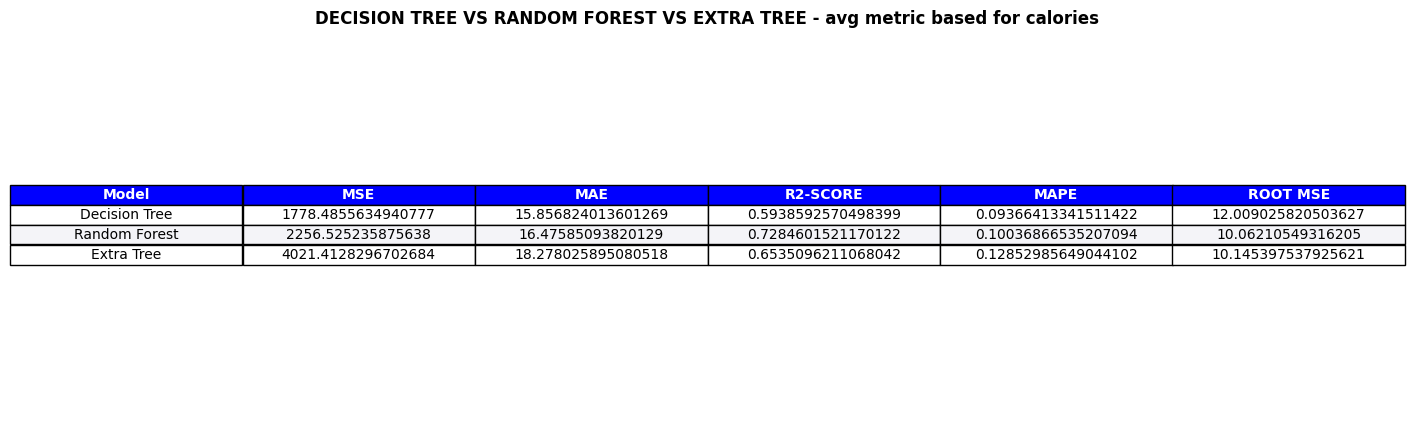

In [59]:
indexes = ['Decision Tree', 'Random Forest', 'Extra Tree']

avg_metrics = {
    'MSE': [tree_mse.mean(), rf_mse.mean(), extra_mse.mean()],
    'MAE': [tree_mae.mean(), rf_mae.mean(), extra_mae.mean()],
    'R2-SCORE': [tree_r2.mean(), rf_r2.mean(), extra_r2.mean()],
    'MAPE': [tree_mape, rf_mape, extra_mape],
    'ROOT MSE': [tree_root_mse5.mean(), rf_root_mse5.mean(), extra_root_mse5.mean()]
}
df_avg1 = pd.DataFrame(avg_metrics)

single_metrics = {
    'MSE' : [tree_mse, rf_mse, extra_mse],
    'MAE' :[tree_mae, rf_mae, extra_mae],
    'R2-SCORE' :[tree_r2, rf_r2, extra_r2],
    'MAPE' :[tree_mape_single, rf_mape_single, extra_mape_single],
    'ROOT MSE ' :[tree_root_mse, rf_root_mse, extra_root_mse]
}

formatted_single_metrics = markdown_table(single_metrics,Y_calories)
df_single = pd.DataFrame(formatted_single_metrics,index=indexes)

print(tabulate(df_single, headers='keys', tablefmt='grid',showindex=True))

fig, axes = plt.subplots(figsize=(15,5))  
create_metric_table(df_avg1, 'DECISION TREE VS RANDOM FOREST VS EXTRA TREE - avg metric based for calories', indexes, axes)
plt.show()

### __HISTOGRAM FOR CALORIES DATASET__

In [106]:

# performs actual prediction and returns an object with the realizations values
def run_trial_calories(user_input,regressor,y):
    user_input_df = pd.DataFrame([user_input])
    predictions = regressor.predict(user_input_df)

    realizations_obj = {
        'Distance (km)': user_input["Distance (km)"],
    }
    for i,col in enumerate(y.columns):
        # print(col)
        # print(predictions[0][i])
        realizations_obj[col] = predictions[0][i] 
    
    return realizations_obj


def construct_user_calories(distance,pace) :
    user = {
        'Distance (km)': distance,
        'Average Pace' : pace,
    }
    return user

# NOTE: users is a list of prdiction objects
def construct_single_feature_user_calories(pred):
    calories = {}
    speed = {}
    distances = ['1.5km', '5km', '10km', '15km', '20km', '25km','30km', '35km']
    
    # NOTE: a prediction user is an object with weight,days,weeklyKM,vo2max
    for i,p in enumerate(pred):
        calories[distances[i]]=p['Calories Burned']
        speed[distances[i]]=p['Average Speed (km/h)']

    return calories,speed

# NOTE: returns a list of prediction objects
def make_trials_calories(regressor,distances, unchanged,y):
    trials = []
    for i,dist in enumerate(distances):
        # NOTE: CALLING run_trial, hence returning prediction objects
        res = run_trial_calories(construct_user_calories(dist, **unchanged), regressor, y)
        trials.append(res)
    return trials

In [109]:
max = calories[['Distance (km)']].max()
min = calories[['Distance (km)']].min()
mid = calories[['Average Pace']].mean()

print(f"min :{min}, max {max}")
print(f"average pace between all : {mid}")

min :Distance (km)    0.76
dtype: float64, max Distance (km)    38.32
dtype: float64
average pace between all : Average Pace    5.317978
dtype: float64


### __EXTRA TREE CALORIES HISTOGRAM__

{'1.5km': 400.3249999971977, '5km': 400.3249999971977, '10km': 694.939830489179, '15km': 1059.165698186735, '20km': 1353.3788991813917, '25km': 1738.852499447161, '30km': 2036.729998836462, '35km': 2229.204998720786}


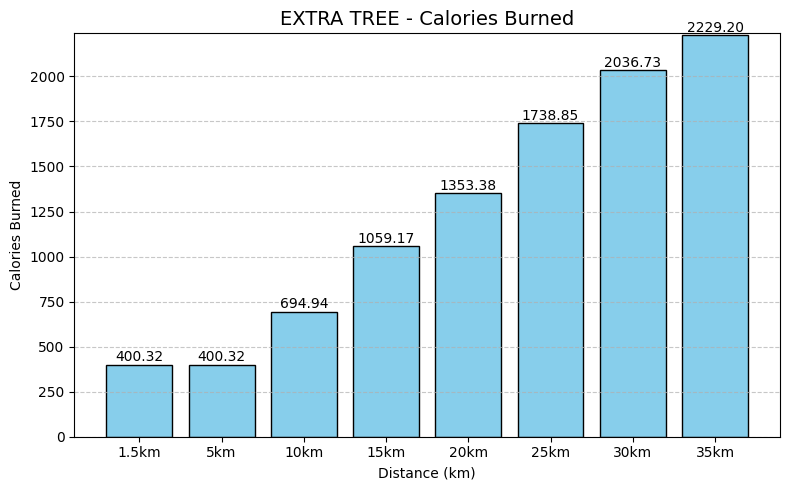

{'1.5km': 11.283399999999949, '5km': 11.283399999999949, '10km': 10.830559357184256, '15km': 10.870668993426618, '20km': 10.547626084428023, '25km': 10.323937500000024, '30km': 10.00130000000002, '35km': 9.501650000000009}


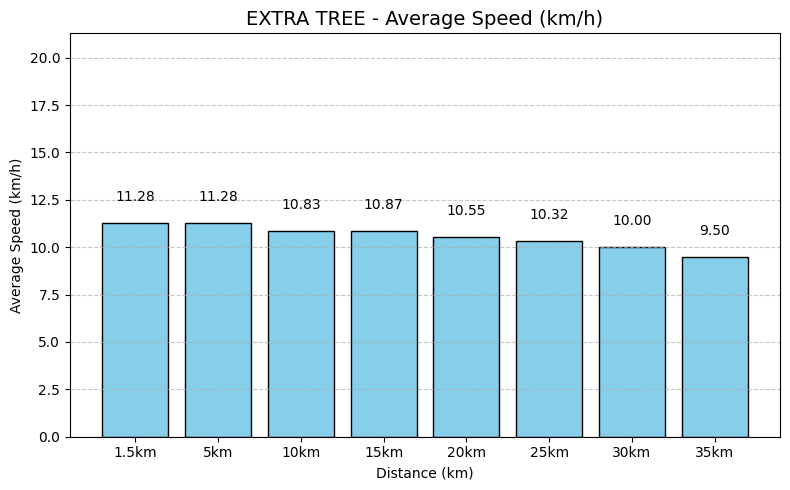

In [110]:
unchanged = {
    'pace' : 5.30,
}
prediction_arr = list(construct_single_feature_user_calories(make_trials_calories(extra,[1.5,5,10,15,20,25,30,35],unchanged,Y_calories1)))

for i,pred_elem in enumerate(prediction_arr):
    title = ['Calories Burned', 'Average Speed (km/h)']
    print(pred_elem)
    plot_histogram_single_features(pred_elem, f'EXTRA TREE - {title[i]}', title[i], 'Distance (km)')

### __RANDOM FOREST CLORIES HISTOGRAM__

{'1.5km': 446.85249991152784, '5km': 446.85249991152784, '10km': 690.019831052133, '15km': 1059.2449999820574, '20km': 1333.9074996141292, '25km': 1740.8599994264948, '30km': 1865.8399991277838, '35km': 2086.1099989574454}


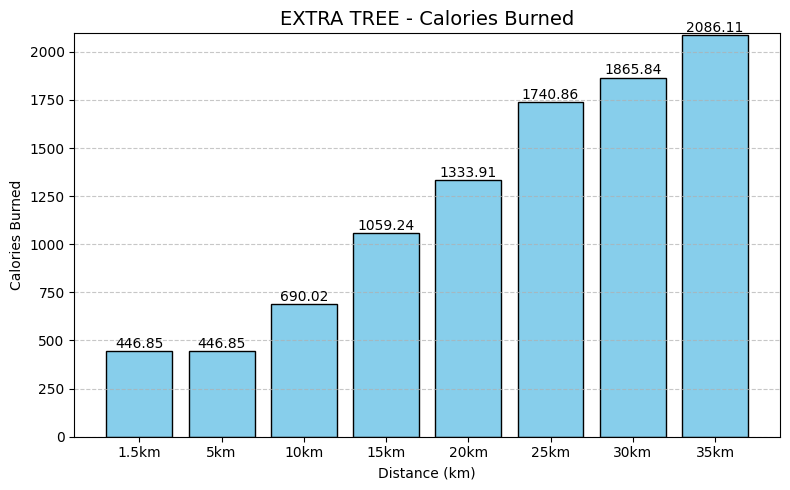

{'1.5km': 10.779450000000002, '5km': 10.779450000000002, '10km': 10.838935515873006, '15km': 10.955399999999964, '20km': 10.704537500000017, '25km': 10.328850000000022, '30km': 10.255150000000024, '35km': 9.74715000000001}


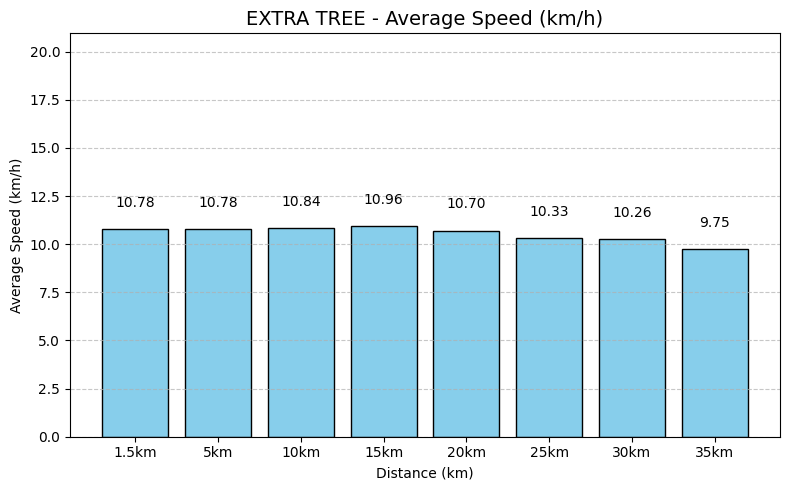

In [111]:
unchanged = {
    'pace' : 5.30,
}
prediction_arr = list(construct_single_feature_user_calories(make_trials_calories(rf,[1.5,5,10,15,20,25,30,35],unchanged,Y_calories1)))

for i,pred_elem in enumerate(prediction_arr):
    title = ['Calories Burned', 'Average Speed (km/h)']
    print(pred_elem)
    plot_histogram_single_features(pred_elem, f'EXTRA TREE - {title[i]}', title[i], 'Distance (km)')

### __DECISION TREE CALORIES HISTOGRAM__

{'1.5km': 395.0, '5km': 395.0, '10km': 685.499999605152, '15km': 1060.0, '20km': 1358.0, '25km': 1793.99999896666, '30km': 1971.99999886413, '35km': 2587.9999985093104}


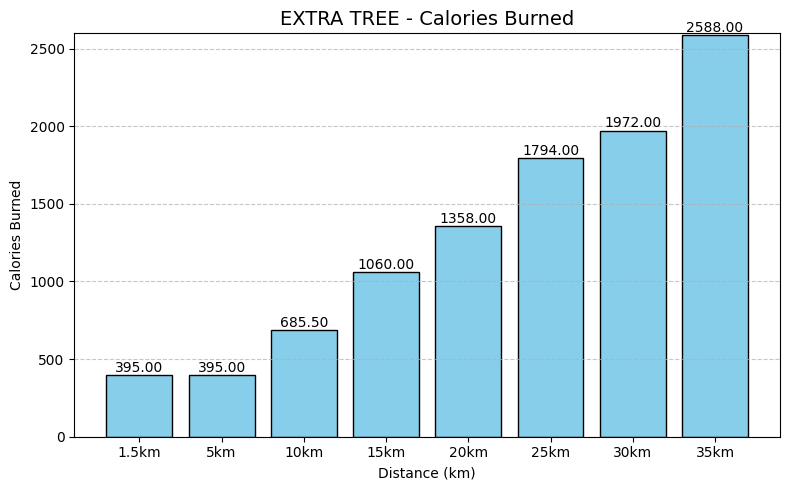

{'1.5km': 11.37, '5km': 11.37, '10km': 11.64, '15km': 11.1, '20km': 10.52, '25km': 10.18, '30km': 10.17, '35km': 8.57}


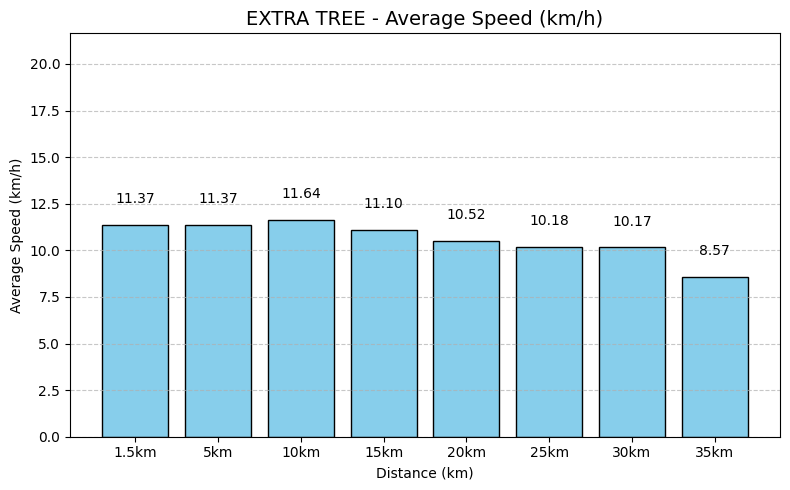

In [112]:
unchanged = {
    'pace' : 5.30,
}
prediction_arr = list(construct_single_feature_user_calories(make_trials_calories(tree,[1.5,5,10,15,20,25,30,35],unchanged,Y_calories1)))

for i,pred_elem in enumerate(prediction_arr):
    title = ['Calories Burned', 'Average Speed (km/h)']
    print(pred_elem)
    plot_histogram_single_features(pred_elem, f'EXTRA TREE - {title[i]}', title[i], 'Distance (km)')

In [274]:
longer = pd.read_csv('exercise_dataset.csv')
longer.head()

,ID,Exercise,Calories Burn,Dream Weight,Actual Weight,Age,Gender,Duration,Heart Rate,BMI,Weather Conditions,Exercise Intensity
0,1,Exercise 2,286.959851,91.892531,96.301115,45,Male,37,170,29.426275,Rainy,5
1,2,Exercise 7,343.453036,64.165097,61.104668,25,Male,43,142,21.286346,Rainy,5
2,3,Exercise 4,261.223465,70.846224,71.766724,20,Male,20,148,27.899592,Cloudy,4
3,4,Exercise 5,127.183858,79.477008,82.984456,33,Male,39,170,33.729552,Sunny,10
4,5,Exercise 10,416.318374,89.960226,85.643174,29,Female,34,118,23.286113,Cloudy,3


In [275]:
longer.isnull().sum()

ID                    0
Exercise              0
Calories Burn         0
Dream Weight          0
Actual Weight         0
Age                   0
Gender                0
Duration              0
Heart Rate            0
BMI                   0
Weather Conditions    0
Exercise Intensity    0
dtype: int64

In [276]:
longer.count()

ID                    3864
Exercise              3864
Calories Burn         3864
Dream Weight          3864
Actual Weight         3864
Age                   3864
Gender                3864
Duration              3864
Heart Rate            3864
BMI                   3864
Weather Conditions    3864
Exercise Intensity    3864
dtype: int64

In [277]:
longer['Gender'].unique()

array(['Male', 'Female'], dtype=object)

In [278]:
def gender_to_binary(g):
    if pd.isna(g):
        return pd.NA 
    elif g == 'Male':
        return 1
    else :
        return 0

longer = longer.drop(columns=['ID', 'Weather Conditions', 'Dream Weight','Exercise'])
longer['Gender'] = longer['Gender'].apply(gender_to_binary) 
longer.head()

,Calories Burn,Actual Weight,Age,Gender,Duration,Heart Rate,BMI,Exercise Intensity
0,286.959851,96.301115,45,1,37,170,29.426275,5
1,343.453036,61.104668,25,1,43,142,21.286346,5
2,261.223465,71.766724,20,1,20,148,27.899592,4
3,127.183858,82.984456,33,1,39,170,33.729552,10
4,416.318374,85.643174,29,0,34,118,23.286113,3


In [279]:
longer = longer[longer['Gender'] == 1]
longer['Gender'].unique()

array([1])

In [280]:
longer.head()

,Calories Burn,Actual Weight,Age,Gender,Duration,Heart Rate,BMI,Exercise Intensity
0,286.959851,96.301115,45,1,37,170,29.426275,5
1,343.453036,61.104668,25,1,43,142,21.286346,5
2,261.223465,71.766724,20,1,20,148,27.899592,4
3,127.183858,82.984456,33,1,39,170,33.729552,10
6,457.631361,61.815386,18,1,53,103,34.594641,10


In [288]:
X_longer = longer[['Heart Rate','Exercise Intensity']]
Y_longer = longer[['Calories Burn','Actual Weight']]

for i in range(len(longer)):
    if pd.notna(longer['Heart Rate'].iloc[i]):
        print(longer['Heart Rate'].iloc[i], longer['Exercise Intensity'].iloc[i])


170 5
142 5
148 4
170 10
103 10
104 2
161 1
103 10
151 3
121 1
174 4
105 9
126 9
149 8
114 7
135 2
145 9
159 2
133 1
118 6
164 10
154 7
168 2
103 7
155 10
153 1
159 7
151 7
158 6
137 2
129 7
124 3
146 3
146 3
136 8
101 8
119 6
174 2
151 4
172 2
147 4
118 1
139 7
153 6
166 4
128 2
145 9
110 10
176 1
110 7
152 6
137 8
139 5
109 5
166 8
163 7
115 10
128 1
166 8
108 9
176 7
151 7
127 4
123 8
151 5
135 7
144 1
122 2
177 9
117 2
108 1
137 1
170 2
160 5
109 7
106 8
100 3
126 5
141 6
176 1
170 5
177 2
154 9
133 3
111 7
162 2
176 3
153 7
136 10
133 5
159 3
158 1
123 10
126 6
130 3
165 9
119 2
171 10
113 4
123 7
160 4
159 10
173 9
116 7
107 10
136 1
110 1
146 6
159 7
136 2
110 5
180 7
120 10
115 10
102 6
135 9
143 6
175 10
139 9
132 6
108 3
143 3
107 7
167 1
164 9
116 1
120 4
137 7
178 8
180 8
132 10
158 2
151 8
166 5
140 9
176 9
138 4
170 2
159 8
113 5
126 10
138 10
108 1
176 3
163 8
103 3
139 10
179 5
157 6
162 7
111 8
122 4
135 6
175 5
172 3
157 6
170 9
180 4
159 8
115 5
170 6
116 7
178 10
15

__WE CANNOT HAVE THIS COMPARISON BECAUSE THE EXERCISE TYPES ARE DIFFERENT HENCE HEART RATE IS ALSOBASED ON THAT AND INTENSITY TOO, THERE ARE TOO MANY DEPENDENCIES__

In [258]:
tree, tree_train, tree_mse, tree_mae, tree_r2, tree_mape, tree_mape_single, tree_root_mse = perform_tree_regression(DecisionTreeRegressor,X_longer,Y_longer,False)
rf, rf_train, rf_mse, rf_mae, rf_r2, rf_mape, rf_mape_single, rf_root_mse = perform_tree_regression(RandomForestRegressor,X_longer,Y_longer,True)
extra, extra_train, extra_mse, extra_mae, extra_r2, extra_mape, extra_mape_single, extra_root_mse = perform_tree_regression(ExtraTreesRegressor,X_longer,Y_longer,True)

+---------------+-------------------------------------------+-------------------------------------------+---------------------------------------------+--------------------------------------------+-------------------------------------------+
|               | MSE                                       | MAE                                       | R2-SCORE                                    | MAPE                                       | ROOT MSE                                  |
+===============+===========================================+===========================================+=============================================+============================================+===========================================+
| Decision Tree | Calories Burned : 14507.60356436857       | Calories Burned : 102.99723401522257      | Calories Burned : -0.09677381774140126      | Calories Burned : 0.4257728440784075       | Calories Burned : 120.44751373261538      |
|               | Average Speed (km/

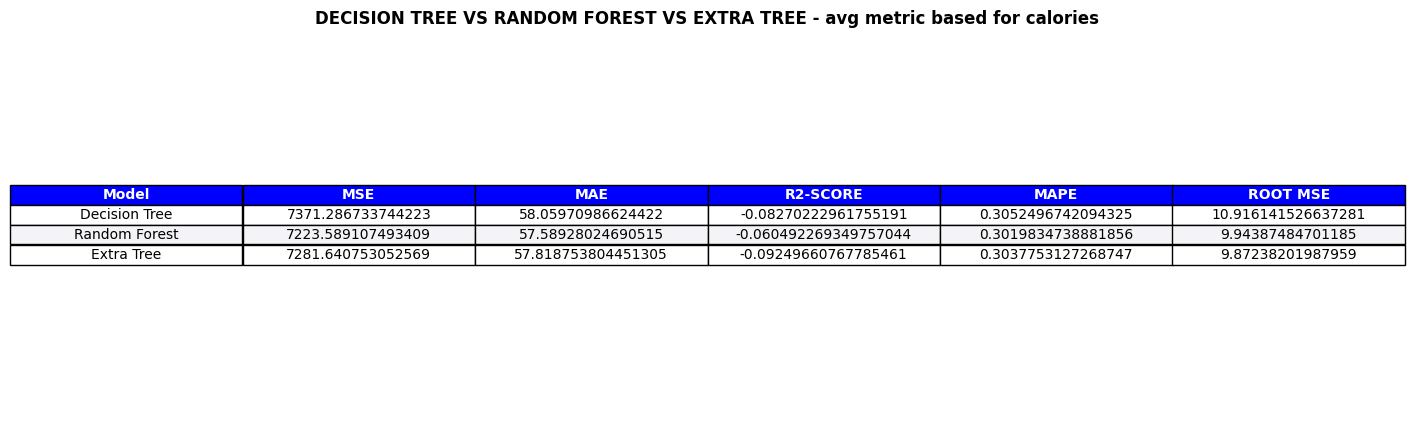

In [259]:
indexes = ['Decision Tree', 'Random Forest', 'Extra Tree']

avg_metrics = {
    'MSE': [tree_mse.mean(), rf_mse.mean(), extra_mse.mean()],
    'MAE': [tree_mae.mean(), rf_mae.mean(), extra_mae.mean()],
    'R2-SCORE': [tree_r2.mean(), rf_r2.mean(), extra_r2.mean()],
    'MAPE': [tree_mape, rf_mape, extra_mape],
    'ROOT MSE': [tree_root_mse5.mean(), rf_root_mse5.mean(), extra_root_mse5.mean()]
}
df_avg1 = pd.DataFrame(avg_metrics)

single_metrics = {
    'MSE' : [tree_mse, rf_mse, extra_mse],
    'MAE' :[tree_mae, rf_mae, extra_mae],
    'R2-SCORE' :[tree_r2, rf_r2, extra_r2],
    'MAPE' :[tree_mape_single, rf_mape_single, extra_mape_single],
    'ROOT MSE ' :[tree_root_mse, rf_root_mse, extra_root_mse]
}

formatted_single_metrics = markdown_table(single_metrics,Y_calories)
df_single = pd.DataFrame(formatted_single_metrics,index=indexes)

print(tabulate(df_single, headers='keys', tablefmt='grid',showindex=True))

fig, axes = plt.subplots(figsize=(15,5))  
create_metric_table(df_avg1, 'DECISION TREE VS RANDOM FOREST VS EXTRA TREE - avg metric based for calories', indexes, axes)
plt.show()

# __HALF-MARATHON MODEL__ 

## __PREPARE DATA__

In [ ]:
data = pd.read_csv('cleaned_data.csv')
data = data.dropna(subset=['Halfmarathon_min'])
X_halfmarathon = data[['Halfmarathon_min','height','age','HRmax', 'yearsTrained']] 
y_halfmarathon = data.drop(columns=[
    'marathon_time_in_minutes',
    'id',
    'Halfmarathon_min',
    'height',
    'age',
    'HRmax',
    'skinfoldCheek', ''
    'skinfoldChin',
    'skinfoldTriceps',
    'skinfoldSubscapular',
    'skinfoldChestI', 
    'skinfoldChestII',
    'skinfoldAbdominal', 
    'skinfoldSuprailiac', 
    'skinfoldThigh',
    'skinfoldCalf', 
    'skinfoldBiceps',
    'yearsTrained',
    'numHalfMarathon',
    'numMarathons'
    ]) 

y_halfmarathon.head()

,weight,bmi,pbf,vo2max,Lactate,RPE,anaerobic_maximalVelocity_min,f0_kg,anaerobic_maximalForce_N,anaerobic_maximalPower_W,...,bestRHGStrength,bestLHGStrength,trunkStrength,trunkLegsStrength,SumStrength,relSumStrength,bestSJ,bestCMJ,days,weeklyKM
0,70.7,23.14,15.6,59.7,15.3,9.5,210.7,16.08,157.74,847.01,...,53.2,60.7,154.5,212.0,480.4,6.79,31.1,36.0,6,65.0
1,71.7,22.63,10.0,46.7,7.6,10.0,205.9,14.50,142.25,746.39,...,49.3,50.8,124.8,142.0,366.9,5.12,22.5,26.6,6,110.0
2,66.2,21.87,12.8,62.0,5.7,9.0,192.8,14.95,146.66,720.59,...,46.9,46.8,109.5,152.0,355.2,5.37,21.1,24.7,5,90.0
3,67.8,20.74,13.7,61.9,10.2,8.0,180.5,17.19,168.63,775.70,...,48.1,49.1,128.0,134.5,359.7,5.31,23.5,24.7,5,65.0
4,68.3,22.18,12.3,50.2,6.8,8.0,188.0,13.43,131.75,631.21,...,54.2,51.7,132.0,167.5,405.4,5.94,19.7,20.7,5,12.5


In [52]:
X_halfmarathon.head()

,Halfmarathon_min,height,age,HRmax,yearsTrained
0,73.0,174.8,36,184.0,24.0
1,78.0,178.0,30,186.0,16.0
2,79.0,174.0,36,180.0,25.0
3,80.0,180.8,41,172.0,3.0
4,83.0,175.5,63,168.0,12.0


## __GRID SEARCH__

In [53]:
gs_dt, gs_scores, grid_searched_tree = grid_searching(DecisionTreeRegressor, X_halfmarathon, y_halfmarathon, 0.2, False)
gs_rf, gs_scores, grid_searched_rf = grid_searching(RandomForestRegressor, X_halfmarathon, y_halfmarathon, 0.2, True)
gs_extra, gs_scores, grid_searched_extra= grid_searching(ExtraTreesRegressor, X_halfmarathon, y_halfmarathon, 0.2, True)

The Best Parameters are : {'max_depth': 6, 'max_features': None, 'min_samples_leaf': 7, 'min_samples_split': 2}
The Best negative MSE Score is : -910.2840653393944


/home/lamberto/.local/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


The Best Parameters are : {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 14, 'n_estimators': 300}
The Best negative MSE Score is : -760.07082296776
The Best Parameters are : {'max_depth': 5, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
The Best negative MSE Score is : -743.6014973997193


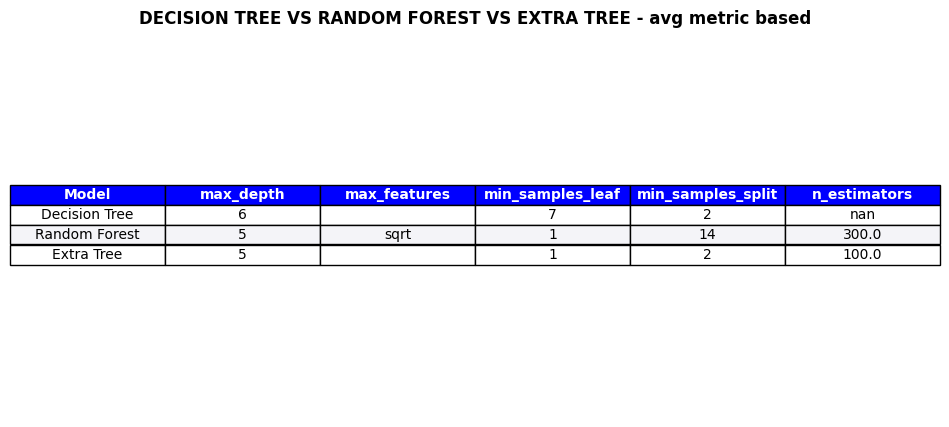

In [54]:
best_params = {
    'max_depth': [gs_dt['max_depth'], gs_rf['max_depth'], gs_extra['max_depth']],
    'max_features':[gs_dt['max_features'], gs_rf['max_features'], gs_extra['max_features']],
    'min_samples_leaf': [gs_dt['min_samples_leaf'], gs_rf['min_samples_leaf'], gs_extra['min_samples_leaf']],
    'min_samples_split': [gs_dt['min_samples_split'], gs_rf['min_samples_split'], gs_extra['min_samples_split']],
    'n_estimators' : [None, gs_rf['n_estimators'], gs_extra['n_estimators'] ]
}

pd_grid_search = pd.DataFrame(best_params)
indexes = ['Decision Tree', 'Random Forest', 'Extra Tree']
size = (10,5)

fig, axes = plt.subplots(figsize=(10,5))  
create_metric_table(pd_grid_search, 'DECISION TREE VS RANDOM FOREST VS EXTRA TREE - avg metric based', indexes, axes)

## __FEATURE EXTRACTION__

In [55]:
dt_features,tree = Feature_extraction(DecisionTreeRegressor,X_halfmarathon,y_halfmarathon,gs_dt,False)
rf_features,rf = Feature_extraction(RandomForestRegressor,X_halfmarathon,y_halfmarathon,gs_rf,True)
extra_features,extra = Feature_extraction(ExtraTreesRegressor,X_halfmarathon,y_halfmarathon,gs_extra,True)

In [59]:
dt_importances = tree.feature_importances_
rf_importances = rf.feature_importances_
extra_imporances = extra.feature_importances_

reg_arr = ['DecisionTreeRegressor', 'RandomForestRegressor', 'ExtraTreesRegressor']
imp_arr = [dt_importances,rf_importances,extra_imporances]

for i in range(len(imp_arr)):
    print('*' * 200)
    print(f'REGRESSOR : {reg_arr[i]} ')
    for j,col in enumerate(X_halfmarathon.columns):
        print(f'importance of {col} : {imp_arr[i][j]}')

print('*' * 200)

********************************************************************************************************************************************************************************************************
REGRESSOR : DecisionTreeRegressor 
importance of Halfmarathon_min : 0.21843800450892126
importance of height : 0.39028938613916025
importance of age : 0.3196357801088442
importance of HRmax : 0.021452626683441948
importance of yearsTrained : 0.05018420255963217
********************************************************************************************************************************************************************************************************
REGRESSOR : RandomForestRegressor 
importance of Halfmarathon_min : 0.21883444064947383
importance of height : 0.29327195289587893
importance of age : 0.23622289495134755
importance of HRmax : 0.10904845179132647
importance of yearsTrained : 0.1426222597119732
***************************************************************************

In [60]:
features_arr = [dt_features,rf_features,extra_features]
reg_arr = ['Decision Tree', 'Random Forest', 'Extra tree']

for i,ft in enumerate(features_arr):
    print(f'The selected features for model -> {reg_arr[i]} are : {ft}')

The selected features for model -> Decision Tree are : Index(['Halfmarathon_min', 'height', 'age'], dtype='object')
The selected features for model -> Random Forest are : Index(['Halfmarathon_min', 'height', 'age'], dtype='object')
The selected features for model -> Extra tree are : Index(['Halfmarathon_min', 'height', 'age'], dtype='object')


Optimal number of features: 3
Selected features: Index(['Halfmarathon_min', 'height', 'age'], dtype='object')


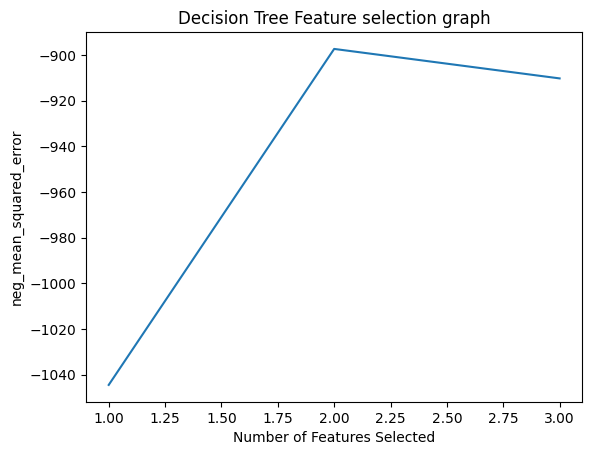

Optimal number of features: 3
Selected features: Index(['Halfmarathon_min', 'height', 'age'], dtype='object')


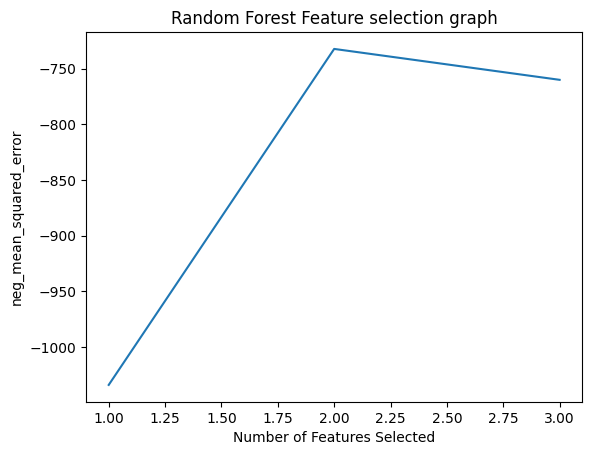

Optimal number of features: 5
Selected features: Index(['Halfmarathon_min', 'height', 'age', 'HRmax', 'yearsTrained'], dtype='object')


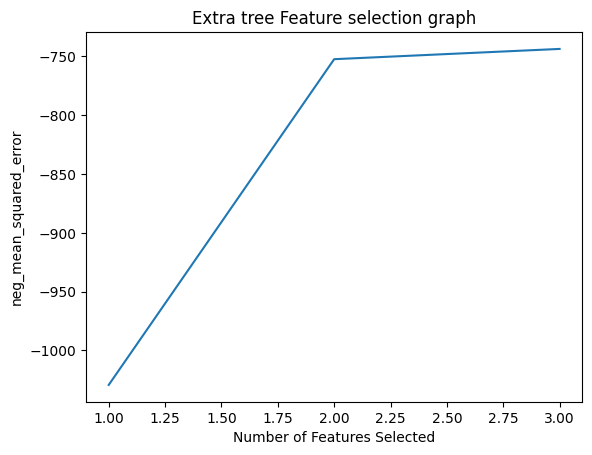

In [61]:
Feature_selection_through_rfecv(DecisionTreeRegressor,X_halfmarathon,y_halfmarathon,False,gs_dt,"Decision Tree Feature selection graph")
Feature_selection_through_rfecv(RandomForestRegressor,X_halfmarathon,y_halfmarathon,True,gs_rf, "Random Forest Feature selection graph")
Feature_selection_through_rfecv(ExtraTreesRegressor,X_halfmarathon,y_halfmarathon,True,gs_extra,"Extra tree Feature selection graph")

In [62]:
tree9, tree_train9, tree_mse9, tree_mae9, tree_r29,  tree_root_mse9 = perform_tree_regression(DecisionTreeRegressor,X_halfmarathon,y_halfmarathon,False)
rf9, rf_train9, rf_mse9, rf_mae9, rf_r29, rf_root_mse9 = perform_tree_regression(RandomForestRegressor,X_halfmarathon,y_halfmarathon,True)
extra9, extra_train9, extra_mse9, extra_mae9, extra_r29, extra_root_mse9 = perform_tree_regression(ExtraTreesRegressor,X_halfmarathon,y_halfmarathon,True)

/home/lamberto/.local/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


The Best Parameters are : {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 9, 'min_samples_split': 2}
The Best negative MSE Score is : -850.0937436357171
The Best Parameters are : {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 14, 'n_estimators': 100}
The Best negative MSE Score is : -748.4402168757796
The Best Parameters are : {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
The Best negative MSE Score is : -714.2988458782349


+---------------+----------------------------------------------------+-----------------------------------------------------+-------------------------------------------------------+-----------------------------------------------------+
|               | MSE                                                | MAE                                                 | R2-SCORE                                              | ROOT MSE                                            |
+===============+====================================================+=====================================================+=======================================================+=====================================================+
| Decision Tree | weight : 114.1208597216119                         | weight : 7.949358076563955                          | weight : -0.6547661008983374                          | weight : 10.682736527763469                         |
|               | bmi : 13.614774735559598                  

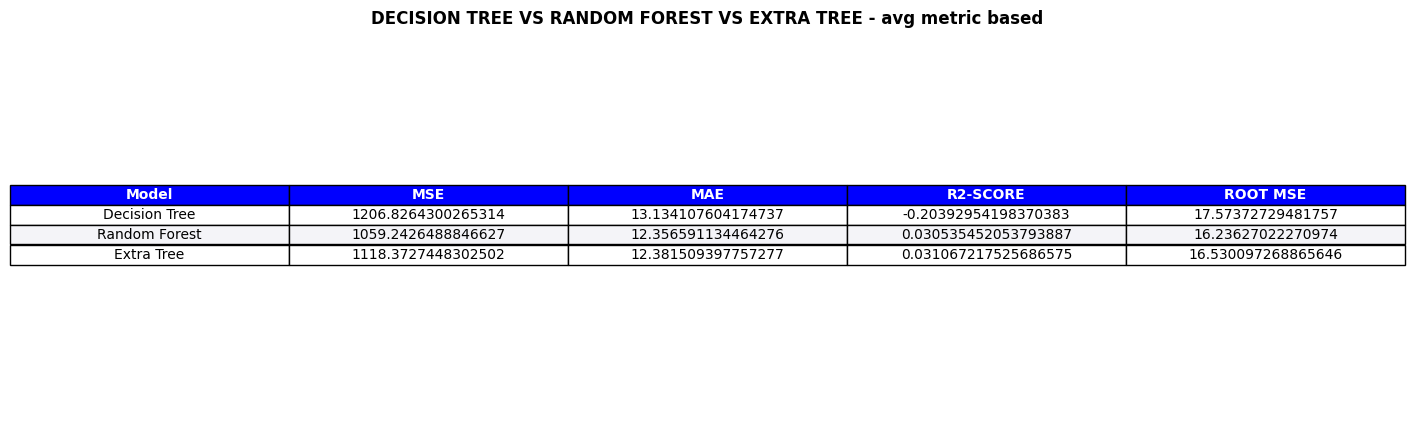

In [66]:
indexes = ['Decision Tree', 'Random Forest', 'Extra Tree']

avg_metrics9 = {
    'MSE': [tree_mse9.mean(), rf_mse9.mean(), extra_mse9.mean()],
    'MAE': [tree_mae9.mean(), rf_mae9.mean(), extra_mae9.mean()],
    'R2-SCORE': [tree_r29.mean(), rf_r29.mean(), extra_r29.mean()],
    # 'MAPE': [tree_mape5, rf_mape5, extra_mape5],
    'ROOT MSE': [tree_root_mse9.mean(), rf_root_mse9.mean(), extra_root_mse9.mean()]
}

df_avg9 = pd.DataFrame(avg_metrics9)

single_metrics9 = {
    'MSE' : [tree_mse9, rf_mse9, extra_mse9],
    'MAE' :[tree_mae9, rf_mae9, extra_mae9],
    'R2-SCORE' :[tree_r29, rf_r29, extra_r29],
    # 'MAPE' :[tree_mape_single5, rf_mape_single5, extra_mape_single5],
    'ROOT MSE ' :[tree_root_mse9, rf_root_mse9, extra_root_mse9]
}
formatted_single_metrics9 = markdown_table(single_metrics9,y_halfmarathon)
df_single9 = pd.DataFrame(formatted_single_metrics9,index=indexes)

print(tabulate(df_single9, headers='keys', tablefmt='grid',showindex=True))

fig, axes = plt.subplots(figsize=(15,5))  
create_metric_table(df_avg9, 'DECISION TREE VS RANDOM FOREST VS EXTRA TREE - avg metric based', indexes, axes)
plt.show()

In [68]:
y_halfmarathon = data[['vo2max', 'weeklyKM', 'anaerobic_maximalPower_W', 'weight']]

In [70]:
tree10, tree_train10, tree_mse10, tree_mae10, tree_r210,  tree_root_mse10 = perform_tree_regression(DecisionTreeRegressor,X_halfmarathon,y_halfmarathon,False)
rf10, rf_train10, rf_mse10, rf_mae10, rf_r210, rf_root_mse10 = perform_tree_regression(RandomForestRegressor,X_halfmarathon,y_halfmarathon,True)
extra10, extra_train10, extra_mse10, extra_mae10, extra_r210, extra_root_mse10 = perform_tree_regression(ExtraTreesRegressor,X_halfmarathon,y_halfmarathon,True)

/home/lamberto/.local/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


The Best Parameters are : {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 12}
The Best negative MSE Score is : -3344.7565985112014
The Best Parameters are : {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 13, 'n_estimators': 100}
The Best negative MSE Score is : -3053.7259648450645
The Best Parameters are : {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
The Best negative MSE Score is : -2832.000602621629


In [ ]:
indexes = ['Decision Tree', 'Random Forest', 'Extra Tree']

avg_metrics10 = {
    'MSE': [tree_mse10.mean(), rf_mse10.mean(), extra_mse10.mean()],
    'MAE': [tree_mae10.mean(), rf_mae10.mean(), extra_mae10.mean()],
    'R2-SCORE': [tree_r210.mean(), rf_r210.mean(), extra_r210.mean()],
    # 'MAPE': [tree_mape5, rf_mape5, extra_mape5],
    'ROOT MSE': [tree_root_mse10.mean(), rf_root_mse10.mean(), extra_root_mse10.mean()]
}

df_avg10 = pd.DataFrame(avg_metrics10)

single_metrics10 = {
    'MSE' : [tree_mse10, rf_mse10, extra_mse10],
    'MAE' :[tree_mae10, rf_mae10, extra_mae10],
    'R2-SCORE' :[tree_r210, rf_r210, extra_r210],
    # 'MAPE' :[tree_mape_single5, rf_mape_single5, extra_mape_single5],
    'ROOT MSE ' :[tree_root_mse10, rf_root_mse10, extra_root_mse10]
}
formatted_single_metrics10 = markdown_table(single_metrics10,y_halfmarathon)
df_single10 = pd.DataFrame(formatted_single_metrics10,index=indexes)

print(tabulate(df_single10, headers='keys', tablefmt='grid',showindex=True))

fig, axes = plt.subplots(figsize=(15,5))  
create_metric_table(df_avg10, 'DECISION TREE VS RANDOM FOREST VS EXTRA TREE - avg metric based', indexes, axes)
plt.show()

# 
REMOVE HALF MARATHON MIN  FROM THE INPUT SET AND SEE THE (ACCURACY)

BIGGER DATASET 

SEEDS WITH 3 SEED AND STANDARD DEV AND MEAN

## __EXPORT THE MODEL__

In [ ]:
import joblib
model_filename = 'extra_tree_running_model.joblib'
joblib.dump(extra15, model_filename)